In [1]:
import sys
import matplotlib.pyplot as plt
from scipy import signal, interpolate, optimize
import scipy.io as scio
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
import colorcet as cc
import pickle
import pandas as pd
import copy
from parse import *
sys.path.append("../SpikeCounter")
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from spikecounter import utils
import lmfit
import importlib
import seaborn as sbs
# plt.style.use("/mnt/c/Users/billj/voltage_traces.mplstyle")
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

In [2]:
def reload_libraries():
    importlib.reload(sc_stats)

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220926_QIF/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/"
cm_string = "cet_CET_R1"
cmap = cm.get_cmap(cm_string)

In [4]:
def round_rel_deviation(arr, factor=100):
    try:
        n_decimals = -int(np.floor(np.min(np.log10(np.abs(arr[arr!=0])/factor))))
    except ValueError:
        n_decimals = 1
    rounded = np.round(arr, n_decimals)
#     print(arr, n_decimals, rounded)
    return rounded

In [5]:
os.makedirs(os.path.join(rootdir, "oversample"), exist_ok=True)

In [6]:
all_data = []
for file in os.listdir(rootdir):
    res = parse("sigma_{sigma:f}_r_{r:f}.mat", file)
    if res is not None:
        try:
            matres = scio.loadmat(os.path.join(rootdir, file))
        except Exception as e:
            print(file)
            continue
        r = utils.round_rel_deviation(matres['r'][0][0], factor=100)
        
#         if r in valid_ticks:
        isi_mu= matres['isi_mu'][0][0]
        isi_std = matres['isi_std'][0][0]
        f = matres['f'][0][0]
        sigma = utils.round_rel_deviation(matres['s'][0][0], factor=100)
        n_peaks = matres['n_peaks'][0][0]
        all_data.append((r, sigma, isi_mu, isi_std, isi_std/isi_mu, f, n_peaks, file))
#             print(r)
#         else:
#             os.rename(os.path.join(rootdir, file), os.path.join(rootdir, "oversample", file))
all_data = pd.DataFrame(all_data, columns = [ "I", "sigma", "isi_mu", "isi_std", "isi_cv", "freq", "n_peaks", "mat_file"])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_102432/591268707.py", line 6, in <module>
    matres = scio.loadmat(os.path.join(rootdir, file))
  File "/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/scipy/io/matlab/mio.py", line 224, in loadmat
    with _open_file_context(file_name, appendmat) as f:
  File "/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/scipy/io/matlab/mio.py", line 17, in _open_file_context
    f, opened = _open_file(file_like, appendmat, mode)
  File "/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/scipy/io/matlab/mio.py", line 39, in _open_file
    return open(file_like, mode), True
KeyboardInterrupt

During handling of

TypeError: object of type 'NoneType' has no len()

In [ ]:
all_data.to_csv(os.path.join(rootdir, "all_data.csv"), index=False)

In [291]:
all_data["sigma"] = all_data["sigma"].astype(float)
all_data["I"] = all_data["I"].astype(float)

In [7]:
all_data = pd.read_csv(os.path.join(rootdir, "all_data.csv"))

In [8]:
min_n_peaks = 50
all_data.loc[all_data["n_peaks"] < min_n_peaks, "isi_cv"] = np.nan

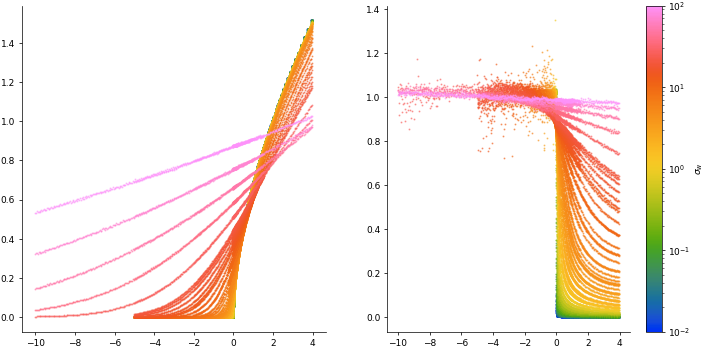

In [9]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
f = pd.pivot_table(all_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(all_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
Is = f.columns.to_numpy()
cmap = cm.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string)
for row in range(len(sigmas)):
    axes[0].scatter(Is, f.iloc[row,:], color=cmap.to_rgba(sigmas[row]),s=1,alpha=0.5)
    axes[1].scatter(Is, covs.iloc[row,:], color=cmap.to_rgba(sigmas[row]),s=1,alpha=0.5)
fig1.colorbar(cmap, label=r"$\sigma_w$")


In [8]:
norm = colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1])

In [9]:
norm(100)

1.0

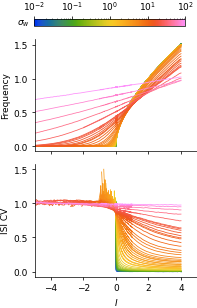

In [80]:
fig1, axes = plt.subplots(2,1, figsize=(3,4))
f = pd.pivot_table(all_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(all_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
Is = f.columns.to_numpy()
cmap = cm.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string)

for row in range(len(sigmas)):
    valid_filter = np.ones_like(Is, dtype=bool)
    valid_filter[(Is < -0.02) & ((covs.iloc[row,:] < 0.95)) | np.isnan(f.iloc[row,:]) | (Is < -1.5) & ((covs.iloc[row,:] > 1.1))] = False
    axes[0].plot(Is[valid_filter], f.iloc[row,valid_filter], color=cmap(norm(sigmas[row])))
    axes[1].plot(Is[valid_filter], covs.iloc[row,valid_filter], color=cmap(norm(sigmas[row])))
#     axes[0].plot(Is[valid_filter], f.iloc[row,valid_filter])
#     axes[1].plot(Is[valid_filter], covs.iloc[row,valid_filter], color=cmap(norm(sigmas[row])))
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("ISI CV")
axes[1].set_xlabel(r"$I$")
axes[0].xaxis.set_ticklabels([])
plt.tight_layout()
cax = plt.axes([0.2, 1.01, 0.7, 0.025])
fig1.colorbar(cm.ScalarMappable(norm=norm), cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position('top')
fig1.text(0.12, 1.015, r"$\sigma_w$")
axes[0].set_xlim(-5, 5)
axes[1].set_xlim(-5, 5)

# cax.set_ylabel(r"$\sigma_w$")
# cax.yaxis.set_label_position('left')
# cax.set_title(r"$\sigma_w$", fontsize=9)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "QIF", "QIF_moments.svg"))

In [78]:
f.index.unique()

Float64Index([              0.01, 0.0133352143216332, 0.0177827941003892,
              0.0237137370566165, 0.0316227766016837, 0.0421696503428582,
              0.0562341325190349, 0.0749894209332455,                0.1,
              0.1333521432163324, 0.1778279410038923, 0.2371373705661655,
              0.3162277660168379, 0.4216965034285822, 0.5623413251903491,
              0.7498942093324559,                1.0,  1.333521432163324,
              1.4444444444444444, 1.7782794100389228, 1.8888888888888888,
               2.333333333333333,  2.371373705661655, 2.7777777777777777,
              3.1622776601683795, 3.2222222222222223, 3.6666666666666665,
               4.111111111111111,  4.216965034285822,  4.555555555555555,
                             5.0,  5.623413251903491,  6.666666666666667,
               7.498942093324558,  8.333333333333334,               10.0,
              11.666666666666668, 13.333333333333334, 13.894954943731374,
                            15.0, 16.6

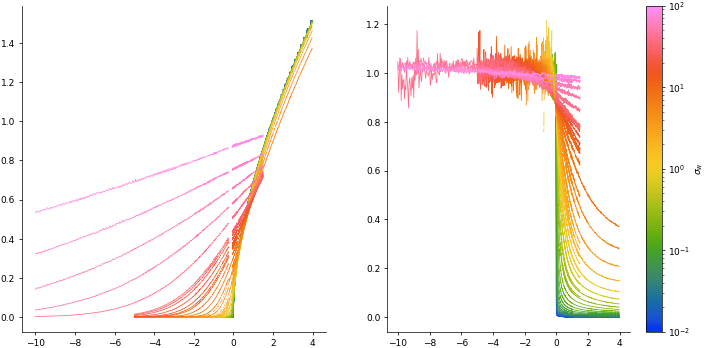

In [33]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
f = pd.pivot_table(all_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(all_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
Is = f.columns.to_numpy()
for row in range(len(sigmas)):
    axes[0].plot(Is, f.iloc[row,:], color=cmap(row/len(sigmas)))
    axes[1].plot(Is, covs.iloc[row,:], color=cmap(row/len(sigmas)))
fig1.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string), label=r"$\sigma_w$")

In [15]:
f.iloc[10].index

Float64Index([-10.0, -9.96, -9.92, -9.88, -9.83, -9.79, -9.75, -9.71, -9.67,
              -9.62,
              ...
               3.85,  3.86,  3.87,  3.88,   3.9,  3.92,  3.93,  3.95,  3.97,
               3.98],
             dtype='float64', name='I', length=1148)

1.89


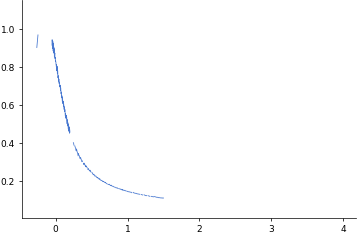

In [72]:
row = 20
print(f.index[row])
plt.plot(covs.iloc[row].index, covs.iloc[row])

In [22]:
data_by_sigma = all_data.set_index("sigma")

In [25]:
q = data_by_sigma.loc[f.index[row]].sort_values("I")

In [29]:
idx = np.argwhere(np.isfinite(q["isi_cv"].values)).ravel()[0]
q.iloc[idx:]

,I,isi_mu,isi_std,isi_cv,freq,n_peaks,mat_file
sigma,,,,,,,
1.89,-0.424,43460.700000,0.000000,0.000000,0.00004,2,sigma_1.888889_r_-0.423750.mat
1.89,-0.408,NaN,NaN,NaN,0.00000,0,sigma_1.888889_r_-0.407500.mat
1.89,-0.391,24631.920000,947.400000,0.038462,0.00006,3,sigma_1.888889_r_-0.391250.mat
1.89,-0.375,10237.750000,4537.609061,0.443223,0.00010,5,sigma_1.888889_r_-0.375000.mat
1.89,-0.359,14961.933333,15471.916592,1.034085,0.00008,4,sigma_1.888889_r_-0.358750.mat
...,...,...,...,...,...,...,...
1.89,3.830,0.680281,0.039684,0.058335,1.46998,73499,sigma_1.888889_r_3.831250.mat
1.89,3.860,0.676758,0.039205,0.057930,1.47764,73882,sigma_1.888889_r_3.865000.mat
1.89,3.900,0.673256,0.038694,0.057472,1.48532,74266,sigma_1.888889_r_3.898750.mat


In [7]:
low_sample = all_data[(all_data["n_peaks"] < 2000)*np.isfinite(all_data["isi_mu"])]

In [8]:
high_sample = all_data[(all_data["n_peaks"] >= 2000)*np.isfinite(all_data["isi_mu"])]

In [9]:
high_sample.sort_values("n_peaks")

,I,sigma,isi_mu,isi_std,isi_cv,freq,n_peaks,mat_file
8107,-0.450,2.371374,5609.796513,5341.846897,0.952235,0.000178,2014,sigma_2.371374_r_-0.445750.mat
1133,-0.200,1.333521,5591.385020,5333.166782,0.953819,0.000179,2021,sigma_1.333521_r_-0.199333.mat
9432,-0.027,0.316228,7435.647069,6833.807148,0.919060,0.000134,2024,sigma_0.316228_r_-0.027083.mat
13367,-0.089,0.749894,5579.207134,5542.060352,0.993342,0.000179,2025,sigma_0.749894_r_-0.088667.mat
8462,-0.190,1.333521,3709.791249,3648.438427,0.983462,0.000270,2035,sigma_1.333521_r_-0.190000.mat
...,...,...,...,...,...,...,...,...
13519,0.320,10.000000,2.517749,1.990309,0.790511,0.397180,1509285,sigma_10.000000_r_0.323000.mat
12949,0.380,1.333521,2.517585,0.528641,0.209980,0.397206,1509383,sigma_1.333521_r_0.375000.mat
13900,0.320,10.000000,2.514446,1.985969,0.789823,0.397702,1511266,sigma_10.000000_r_0.324708.mat
68,0.380,1.333521,2.513899,0.526575,0.209465,0.397789,1511597,sigma_1.333521_r_0.375958.mat


In [10]:
low_sample.sort_values("n_peaks")

,I,sigma,isi_mu,isi_std,isi_cv,freq,n_peaks,mat_file
13721,-0.170,1.000000,128524.481026,100703.722363,0.783537,0.000008,118,sigma_1.000000_r_-0.175000.mat
8895,-0.390,1.778279,116568.710233,109020.417893,0.935246,0.000009,130,sigma_1.778279_r_-0.385958.mat
12160,-0.570,2.371374,106647.968369,102520.448295,0.961298,0.000009,142,sigma_2.371374_r_-0.575000.mat
2268,-0.570,2.371374,98283.421830,96192.620584,0.978727,0.000010,154,sigma_2.371374_r_-0.570458.mat
13428,-0.170,1.000000,91135.541333,86789.484739,0.952312,0.000011,166,sigma_1.000000_r_-0.171333.mat
...,...,...,...,...,...,...,...,...
415,-0.093,0.749894,8010.966092,7390.372775,0.922532,0.000125,1879,sigma_0.749894_r_-0.092667.mat
3089,-0.210,1.333521,7681.542278,7033.266915,0.915606,0.000130,1959,sigma_1.333521_r_-0.206000.mat
10196,-0.140,1.000000,7679.732251,7114.798942,0.926438,0.000130,1960,sigma_1.000000_r_-0.138000.mat
3490,-1.500,5.623413,7582.328448,7144.618502,0.942272,0.000132,1985,sigma_5.623413_r_-1.525000.mat


In [33]:
low_sample[low_sample["isi_cv"]>0.99].shape

(25, 8)

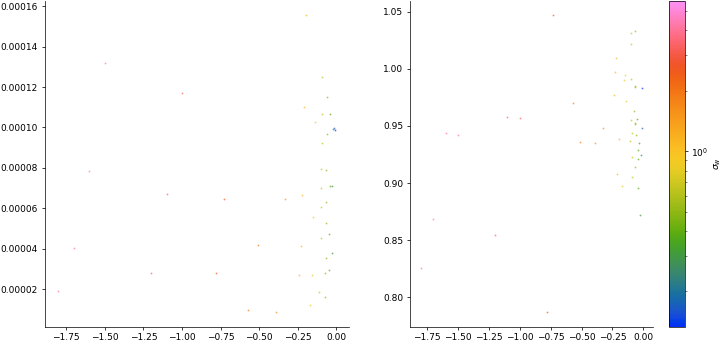

In [11]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
f = pd.pivot_table(low_sample, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(low_sample, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
Is = f.columns.to_numpy()
for row in range(len(sigmas)):
    axes[0].scatter(Is, f.iloc[row,:], color=cmap(row/len(sigmas)),s=1,alpha=0.5)
    axes[1].scatter(Is, covs.iloc[row,:], color=cmap(row/len(sigmas)),s=1,alpha=0.5)
fig1.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string), label=r"$\sigma_w$")

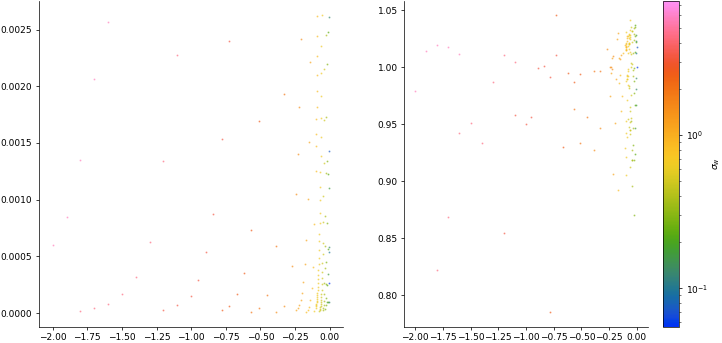

In [9]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
f = pd.pivot_table(all_data[(all_data["n_peaks"] < 20000)*np.isfinite(all_data["isi_mu"])], values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(all_data[(all_data["n_peaks"] < 20000)*np.isfinite(all_data["isi_mu"])], values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
Is = f.columns.to_numpy()
for row in range(len(sigmas)):
    axes[0].scatter(Is, f.iloc[row,:], color=cmap(row/len(sigmas)),s=1,alpha=0.5)
    axes[1].scatter(Is, covs.iloc[row,:], color=cmap(row/len(sigmas)),s=1,alpha=0.5)
fig1.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string), label=r"$\sigma_w$")

In [27]:
sigmas

array([1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
       3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
       1.00000000e+00, 1.33352143e+00, 1.44444444e+00, 1.77827941e+00,
       1.88888889e+00, 2.33333333e+00, 2.37137371e+00, 2.77777778e+00,
       3.16227766e+00, 3.22222222e+00, 3.66666667e+00, 4.11111111e+00,
       4.21696503e+00, 4.55555556e+00, 5.00000000e+00, 5.62341325e+00,
       6.66666667e+00, 7.49894209e+00, 8.33333333e+00, 1.00000000e+01,
       1.16666667e+01, 1.33333333e+01, 1.38949549e+01, 1.50000000e+01,
       1.66666667e+01, 1.83333333e+01, 1.93069773e+01, 2.00000000e+01,
       2.68269580e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02])

In [10]:
rootdir_expt = "/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/Firefly/"
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [os.path.join(rootdir_expt, d) for d in expts]
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(os.path.join(datadir, "", "analysis/all_moments.mat")))

In [11]:
unaligned_frequencies = []
unaligned_covs = []
all_index_offsets = []
for i in range(len(expt_moments)):
    moments = expt_moments[i]
    unaligned_frequencies.append(moments["all_freqs"])
    unaligned_covs.append(moments["covs"])
    all_index_offsets.append(moments["idx_offsets"].ravel())
dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

In [12]:
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[0] = 1100
index_cutoffs[1] = 1125

index_cutoffs[4] = 1220
index_cutoffs[5] = 1180

index_cutoffs[6] = 1250
index_cutoffs[7] = 1100
index_cutoffs[8] = 1150

index_cutoffs[9] = 1300
index_cutoffs[10] = 1250
index_cutoffs[11] = 1250
index_cutoffs[12] = 1000

index_cutoffs[18] = 1100
index_cutoffs[19] = 1220
index_cutoffs[20] = 950
index_cutoffs[21] = 1000

for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

In [13]:
freq_mats = []
cov_mats = []
for i in range(3):
    moments = expt_moments[i]
    freq_mats.append(moments["all_freqs"])
    cov_mats.append(moments["covs"])

n_embryos = [fm.shape[0] for fm in freq_mats]
n_embryos_cumulative = np.cumsum([0] + n_embryos)
max_duration_freq = np.max([fm.shape[1] for fm in freq_mats])
max_duration_cov = np.max([covmat.shape[1] for covmat in cov_mats])

all_expt_freqs = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_freq))
ecov = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_cov))
for i in range(len(freq_mats)):
    fm = freq_mats[i]
    covmat = cov_mats[i]
    all_expt_freqs[n_embryos_cumulative[i]:n_embryos_cumulative[i+1],:fm.shape[1]] = fm
    ecov[n_embryos_cumulative[i]:n_embryos_cumulative[i+1], :covmat.shape[1]] = covmat

In [14]:
f_sim = f.to_numpy()
cov_sim = covs.to_numpy()
rs = Is

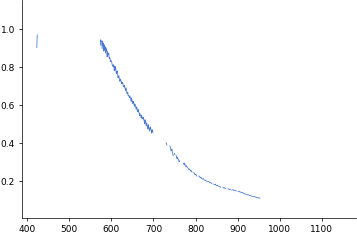

In [74]:
plt.plot(cov_sim[20])

In [15]:
np.savez(os.path.join(rootdir, "all_sigmas.npz"), sigmas=sigmas)

In [15]:
d1 = (np.diff(f_sim, axis=1, prepend=f_sim[:,0][:,None]))/np.diff(Is, prepend=Is[0]*2-Is[1])
d2 = np.diff(d1, axis=1, prepend=d1[:,0][:,None])/np.diff(Is, prepend=Is[0]*2-Is[1])

In [16]:
interp_functions = [interpolate.interp1d(rs[np.isfinite(f_sim[i,:])], f_sim[i,np.isfinite(f_sim[i,:])],\
                        bounds_error=False, fill_value=0) for i in range(f_sim.shape[0])]
interp_functions_cov = [interpolate.interp1d(rs[np.isfinite(cov_sim[i,:])], cov_sim[i,np.isfinite(cov_sim[i,:])],\
                             bounds_error=False, fill_value=np.nan) for i in range(cov_sim.shape[0])]
dr = 0.02
eq_sp_rs = np.arange(np.min(rs), np.max(rs), step=dr)
f_interp = np.array([interp_functions[i](eq_sp_rs) for i in range(f_sim.shape[0])])
cov_interp = np.array([interp_functions_cov[i](eq_sp_rs) for i in range(f_sim.shape[0])])
f_interp_smoothed = signal.savgol_filter(f_interp, 51, 3, axis=1)
# dr2 = 0.05

In [17]:
# interp_functions2 = [interpolate.interp1d(eq_sp_rs, f_interp_smoothed[i], bounds_error=False) for i in range(f_sim.shape[0])]

# f_interp = np.array([interp_functions[i](rs) for i in range(f_sim.shape[0])])
d1 = np.gradient(f_interp_smoothed, axis=1)
d2 = np.gradient(d1, axis=1)

In [18]:
first_idx = 10

In [19]:
last_idx = np.argwhere(eq_sp_rs > 0.01).ravel()[0]
max_diff_f = np.nanargmax(d2[:,first_idx:last_idx], axis=1)+first_idx


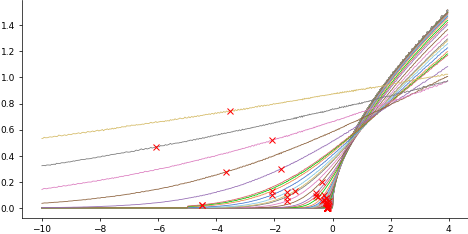

In [20]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(eq_sp_rs, f_interp.T)
for i in range(f_sim.shape[0]):
    plt.plot(eq_sp_rs[max_diff_f[i]], f_interp[i,max_diff_f[i]], "rx")
#     print(eq_sp_rs[max_diff_f[i]], f_interp[i,max_diff_f[i]])
# ax1.set_xlim(-0.2, 0.2)

[527 527 527 527 527 527 527 527 527 527 506 506 506 506 506 506 506 506
 506 506 506 506 506 506 506 506 506 506 506 506 508 508 521 509 663 669
 616 658 658 610 657 636 609 637 658 659 652 632 663]


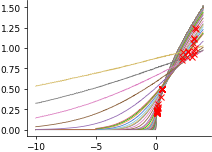

In [21]:
last_idx = np.argwhere(eq_sp_rs > 0.1).ravel()[0]
min_diff_f = np.nanargmax(d2[:,last_idx:], axis=1)+last_idx

#For discontinuity in subcritical Hopf, do it by eye
# min_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 47).ravel()[0]

print(min_diff_f)
plt.plot(eq_sp_rs, f_interp.T)
for i in range(f_sim.shape[0]):
    plt.plot(eq_sp_rs[min_diff_f[i]], f_interp[i,min_diff_f[i]], "rx")

In [22]:
np.savez(os.path.join(rootdir, "big_sigmas.npz"), sigmas=sigmas[-5:])

In [23]:
rs[max_diff_f]

array([-0.155, -0.155, -0.155, -0.155, -0.155, -0.155, -0.155, -0.155,
       -0.155, -0.155, -0.155, -0.155, -0.155, -0.155, -0.155, -0.155,
       -0.155, -0.155, -0.153, -0.153, -0.153, -0.153, -0.153, -0.151,
       -0.157, -0.157, -0.157, -0.157, -0.157, -0.162, -0.166, -0.162,
       -0.174, -0.179, -0.178, -0.166, -0.266, -0.266, -0.225, -0.266,
       -0.44 , -0.44 , -1.54 , -1.54 , -0.328, -0.997, -0.44 , -3.1  ,
       -0.949])

In [24]:
rs_cutoff = -0.5
start_point = np.ones(cov_sim.shape[0], dtype=int)*rs_cutoff

In [25]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)

In [26]:
x_offset_post = 0
n_embryos = aligned_frequencies.shape[0]
#including nans
scale_factors = [1000,1/1.5,5]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))

In [ ]:
# # for row in [21]:
# print("Total fits: ", len(sigmas)*n_embryos)
# for row in range(len(sigmas)):
#     fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
#                                                        540, 0, scale_factors, relweight=1,critical_point=None)
#     characteristic_scale = ((eq_sp_rs[min_diff_f[row]] - eq_sp_rs[max_diff_f[row]]))\
#                             /np.mean(n_valid)
    
#     print(characteristic_scale*np.mean(n_valid))
#     print(eq_sp_rs[max_diff_f[row]])

In [85]:
reload_libraries()

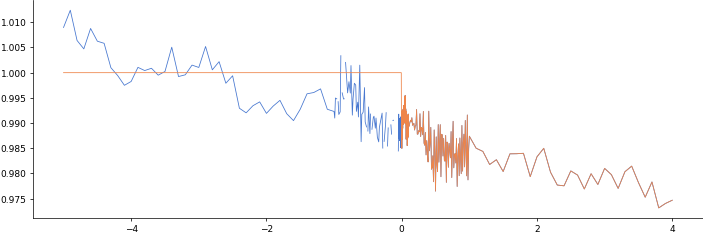

In [79]:
idx = -1
ccov = sc_stats.correct_cov(cov_sim[idx,:], rs, critical_point=0)
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(rs, cov_sim[idx,:])
ax1.plot(rs, ccov)

In [132]:
plt.close("all")
reload_libraries()

In [ ]:
"""
Equation of scaling
f_expt*c/sf[1] = f_sim((t_expt-t_offset_pre)/sf[0]*a + b/sf[2])
"""
n_repeats = 5
print("Total fits: ", len(sigmas)*n_embryos)
# for row in [18]:
for row in range(len(sigmas)):
    print("Sigma: ", sigmas[row])
    scale_factors[1] = 1/np.nanmax(f_sim[row,:])
    print(scale_factors[1])
    fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, 0, scale_factors, relweight=1,critical_point=None)
    characteristic_scale = ((eq_sp_rs[min_diff_f[row]] - eq_sp_rs[max_diff_f[row]]))\
                            /np.mean(n_valid)
#     print(characteristic_scale*np.mean(n_valid))
    flookup_nm[row] = f_lookup
    covlookup_nm[row] = cov_lookup
#     for embryo in [12]:
    for embryo in range(n_embryos):
        f_expt = aligned_frequencies[embryo,:]
        cov_expt = aligned_covs[embryo,:]
        bounds_embryo = np.array([[characteristic_scale*scale_factors[0], characteristic_scale*5*scale_factors[0]], \
          [0.2, 2], \
            [((rs[np.argwhere(cov_sim[row]>0).ravel()[0]]-characteristic_scale*np.mean(n_valid)/2*0.1)*scale_factors[2]),\
           (eq_sp_rs[max_diff_f[row]]+characteristic_scale*np.mean(n_valid)/2)*scale_factors[2]]])
#         print(bounds_embryo)
        bounds[embryo,row,:,:] = bounds_embryo
        curr_min_err = np.inf
        curr_params = None
#         for i in range(3):
        for alpha in np.linspace(0.05, 0.95, n_repeats):
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scale*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=bounds_embryo[2,0]+(bounds_embryo[2,1]-bounds_embryo[2,0])*alpha,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            try:
                out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=10000, method="ampgo", tabulistsize=10, eps1=0.08)
                err = np.nanmean(fitfun(out.params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2)
                if err < curr_min_err:
                    curr_params = out.params
                    curr_min_err = err
            except Exception as e:
                print("Max fev exceeded")
                pass
#                 print(i, curr_min_err)
        err_nm[embryo, row] = curr_min_err
        beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
#         np.savez(os.path.join(figdir, "Data", "QIF_individual_fits_4.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
        if (row*n_embryos+embryo)%100 == 0:
            print("Fit %d complete" % (row*n_embryos+embryo))
    print("Mean err:", np.mean(err_nm[:,row]))
# np.savez(os.path.join("../all_widefield_data/individual_fits.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
np.savez(os.path.join(figdir, "Data", "QIF_individual_fits_5.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

Total fits:  1911
Sigma:  0.01
0.6600050160381219
Fit 0 complete


In [143]:
q = np.load(os.path.join(figdir, "Data", "QIF_individual_fits_5.npz"))
err_nm = q["err_nm"]
beta_nm = q["beta_nm"]
err_individual = np.tile(np.zeros_like(err_nm), (2,1,1))

In [144]:
plt.close("all")

In [145]:
reload_libraries()

In [146]:
for row in range(len(sigmas)):
    scale_factors[1] = 1/np.nanmax(f_sim[row,:])
    for embryo in range(err_nm.shape[0]):
        f_expt = aligned_frequencies[embryo,:]
        cov_expt = aligned_covs[embryo,:]
        
        params = {}
        params['x_scale'] = beta_nm[embryo,row,0]
        params['amplitude'] = beta_nm[embryo,row,1]
        params['x_offset'] = beta_nm[embryo,row,2]
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, 0, scale_factors, relweight=1,critical_point=None)
        
        res = fitfun(params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2
        freq_valid = ~np.isnan(f_expt)
        n_freq_pts = np.sum(freq_valid)
        cov_valid = ~np.isnan(cov_expt)
        res_freq = res[:n_freq_pts]/(scale_factors[1]**2)*(1/np.nanmax(f_sim[row,:]))**2
        res_cov = res[n_freq_pts:]
        err_individual[0,embryo,row] = np.sum(res_freq)
        err_individual[1,embryo,row] = np.sum(res_cov)
#         err_nm[embryo,row] = res_freq + res_cov
    err_nm = np.sum(err_individual, axis=0)

In [ ]:
%matplotlib inline
print(np.sum(fitfun(out.params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2))
paramtest = copy.deepcopy(out.params)
new_amplitude = 0.62
paramtest['amplitude'].value = new_amplitude
print(np.sum(fitfun(paramtest, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2))

fig1, axes = plt.subplots(1, 2, figsize=(10,3))
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
#     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
finite_mask = np.isfinite(frequency) & np.isfinite(cov)
axes[0].plot(rs[finite_mask], frequency[finite_mask], color="black")
axes[1].plot(rs[finite_mask], cov[finite_mask], color="black")
f_expt = aligned_frequencies[e,:]
cov_expt = aligned_covs[e,:]
axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label=(row, sigmas[row]))
axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].plot(xvals_data_scaled[e], f_expt*paramtest['amplitude'].value/scale_factors[1], alpha=0.5, label=(row, sigmas[row]))


In [147]:
mean_lstsq = np.nanmean(err_nm, axis=0)
std_lstsq = np.nanstd(err_nm, axis=0)
mean_lstsq_freq = np.nanmean(err_individual[0], axis=0)
mean_lstsq_cv = np.nanmean(err_individual[1], axis=0)

std_lstsq_freq = np.nanstd(err_individual[0], axis=0)
std_lstsq_cv = np.nanstd(err_individual[1], axis=0)

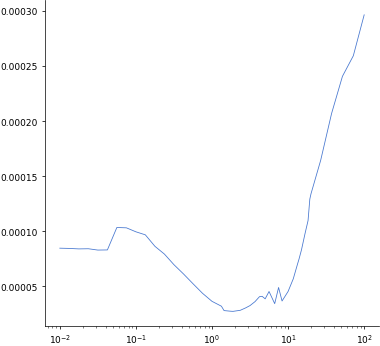

In [26]:
%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.plot(sigmas, mean_lstsq)

ax1.set_xscale("log")

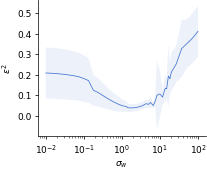

In [151]:
valid_mask = np.ones_like(sigmas, dtype=bool)
# valid_mask[[44,45]] = False
fig1, ax1 = plt.subplots(figsize=(3,2.5))
# ax1.plot(sigmas[valid_mask], median_lstsq[valid_mask])
ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask])
ax1.fill_between(sigmas[valid_mask], mean_lstsq[valid_mask]-std_lstsq[valid_mask],\
                 mean_lstsq[valid_mask]+std_lstsq[valid_mask], alpha=0.1)
# ax1.plot(sigmas[valid_mask], mean_lstsq_cv[valid_mask])
# ax1.fill_between(sigmas[valid_mask], mean_lstsq_cv[valid_mask]-std_lstsq_cv[valid_mask],\
#                  mean_lstsq_cv[valid_mask]+std_lstsq_cv[valid_mask], alpha=0.1)
# ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel(r"$\sigma_w$")
ax1.set_ylabel(r"$\epsilon^2$")
# ax2 = ax1.twinx()
# ax2.plot(sigmas[valid_mask], mean_lstsq_freq[valid_mask], color="C2")
# ax2.fill_between(sigmas[valid_mask], mean_lstsq_freq[valid_mask]-std_lstsq_freq[valid_mask],\
#                  mean_lstsq_freq[valid_mask]+std_lstsq_freq[valid_mask], alpha=0.1, color="C2")

plt.savefig(os.path.join(figdir, "Supplementary Figures", "QIF", "MSE_noise.svg"))

# ax1.set_xlim(0, 21)

In [149]:
sigmas[np.argmin(mean_lstsq)]

1.89

In [82]:
aligned_frequencies.shape

(39, 1602)

In [41]:
print(sigmas[20])

1.89


In [62]:
scale_factors[1]

0.6666666666666666

[ 1.15930179  0.56130016 -0.10005191]
[[ 0.33523669  1.67618346]
 [ 0.5         2.        ]
 [-2.025      -0.1       ]]
[ 1.67618346  0.64131833 -0.1       ]
[[ 0.33523669  1.67618346]
 [ 0.5         2.        ]
 [-2.025      -0.1       ]]
[ 0.59208351  0.5        -0.1       ]
[[ 0.33523669  1.67618346]
 [ 0.5         2.        ]
 [-2.025      -0.1       ]]
[ 1.16970323  0.6448511  -0.1       ]
[[ 0.33523669  1.67618346]
 [ 0.5         2.        ]
 [-2.025      -0.1       ]]
[ 1.5064725   0.57998949 -0.10000004]
[[ 0.33523669  1.67618346]
 [ 0.5         2.        ]
 [-2.025      -0.1       ]]


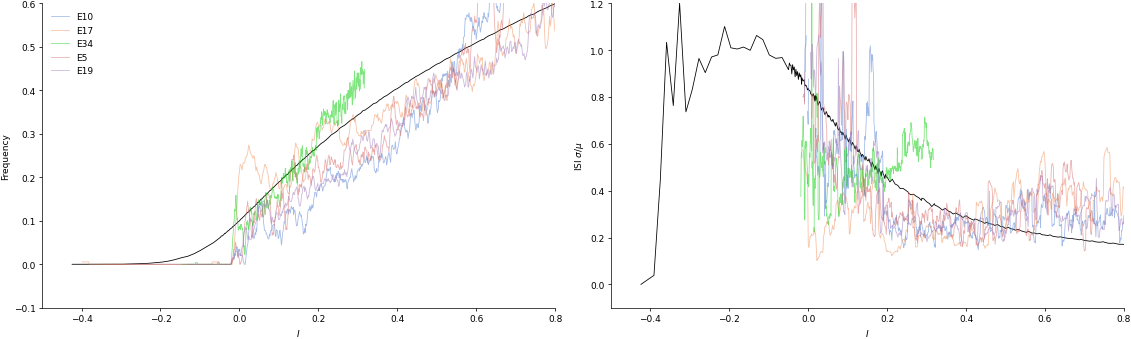

In [42]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 20
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post

dIdt = beta_nm[:,row,0]/scale_factors[0]/dt
finite_mask = np.isfinite(frequency) & np.isfinite(cov)
axes[0].plot(rs[finite_mask], frequency[finite_mask], color="black")
axes[1].plot(rs[finite_mask], cov[finite_mask], color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
xmax = 0.8
axes[0].set_xlim((-0.5,xmax))
axes[1].set_xlim((-0.5,xmax))
axes[0].set_ylim((-0.1,0.6))

axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

In [98]:
plt.close("all")
fig1, axes = plt.subplots(aligned_frequencies.shape[0], 2, figsize=(10,3*aligned_frequencies.shape[0]))
# axes = axes.ravel()
row = 19
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] +



for e in range(aligned_frequencies.shape[0]):
#     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
    axes[e,0].plot(rs, frequency, color="black")
    axes[e,1].plot(rs, cov, color="black")
#     print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[e,0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1], alpha=0.5, label="E%d" % e)
    axes[e,1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
    axes[e,0].legend()
    axes[e,0].set_xlabel(r"$I$")
    axes[e,1].set_xlabel(r"$I$")
    axes[e,0].set_ylabel("Frequency")
    axes[e,1].set_ylabel(r"ISI $\sigma/\mu$")
    xmax = 0.8
    axes[e,0].set_xlim((-0.5,xmax))
    axes[e,1].set_xlim((-0.5,xmax))
    axes[e,0].set_ylim((-0.1,0.6))

    axes[e,1].set_ylim((-0.1, 1.2))
#     fig1.suptitle(beta_nm[e,row,:])
    plt.tight_layout()
plt.savefig("/n/cohen_lab/Lab/Labmembers/Bill Jia/Update Slides/Update Slides 20220930/QIF_individual_fits.svg")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2acd1709a040> (for post_execute):


KeyboardInterrupt: 

In [57]:
from base64 import b64encode
from io import BytesIO

from IPython.display import display, HTML
import matplotlib.pyplot as plt

def add_split_screen(fig, text, iwidth=None):
    figdata = BytesIO()
    fig.savefig(figdata, format='png')
    iwidth = ' width={0} '.format(iwidth) if iwidth is not None else ''
    datatable = '<table><tr><td><img src="data:image/png;base64,{0}"/></td><td>{1}</td></tr></table>'.format(b64encode(figdata.getvalue()).decode(), text)
    display(HTML(datatable)) 

In [81]:
sigmas

array([1.00e-02, 1.33e-02, 1.78e-02, 2.37e-02, 3.16e-02, 4.22e-02,
       5.62e-02, 7.50e-02, 1.00e-01, 1.33e-01, 1.78e-01, 2.37e-01,
       3.16e-01, 4.22e-01, 5.62e-01, 7.50e-01, 1.00e+00, 1.33e+00,
       1.44e+00, 1.78e+00, 1.89e+00, 2.33e+00, 2.37e+00, 2.78e+00,
       3.16e+00, 3.22e+00, 3.67e+00, 4.11e+00, 4.22e+00, 4.56e+00,
       5.00e+00, 5.62e+00, 6.67e+00, 7.50e+00, 8.33e+00, 1.00e+01,
       1.17e+01, 1.33e+01, 1.39e+01, 1.50e+01, 1.67e+01, 1.83e+01,
       1.93e+01, 2.00e+01, 2.68e+01, 3.73e+01, 5.18e+01, 7.20e+01,
       1.00e+02])

,[ 3.28039928 0.65256237 -2.81563332] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

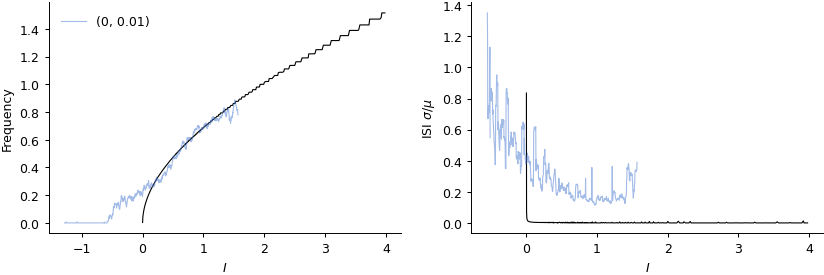

,[ 2.01916256 0.60020085 -1.25797504] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

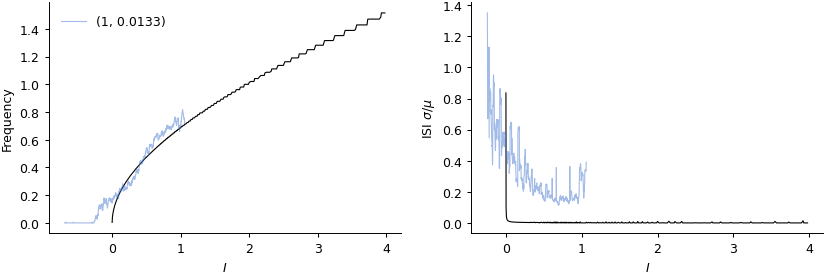

,[ 3.6175844 1.18626833 -2.84991397] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

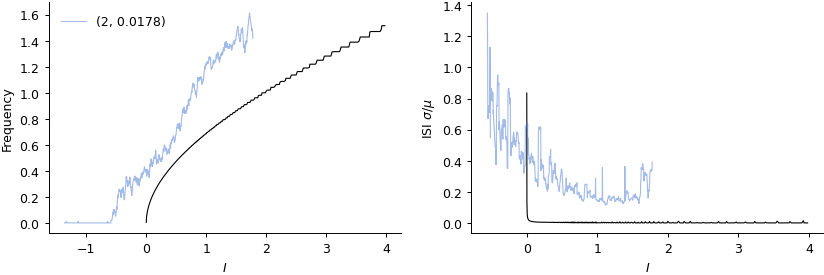

,[ 2.18440987 0.66278783 -2.31114486] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

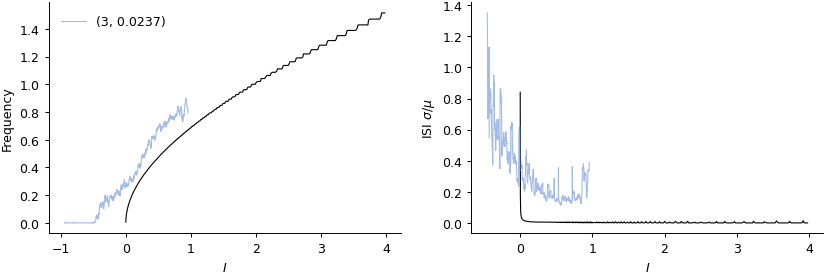

,[ 2.05067588 0.60640955 -1.11458157] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

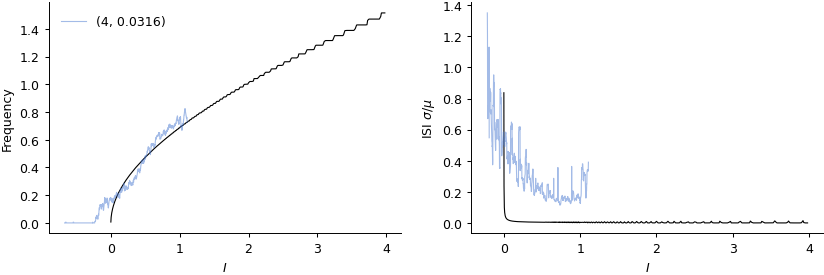

,[ 3.42100395 0.65428341 -2.84901192] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

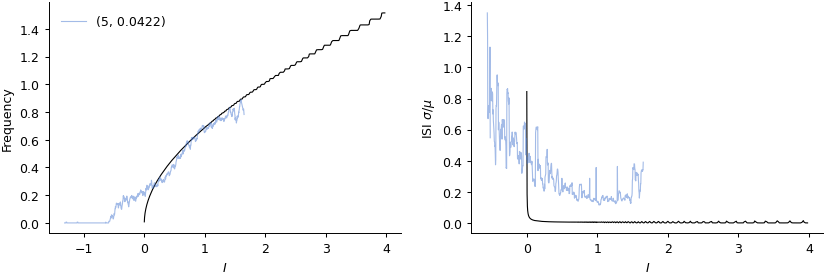

,[ 2.20983031 0.60004214 -1.36805049] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

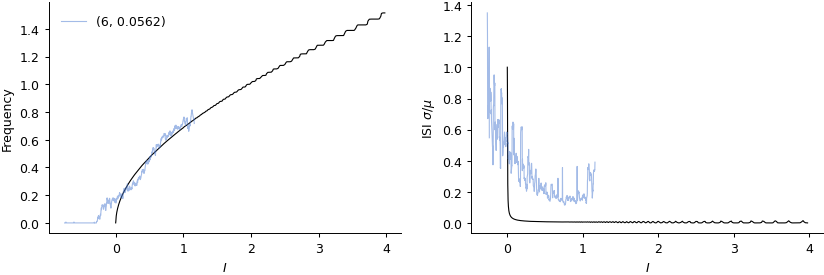

,[ 3.88840666 0.81292582 -2.23125991] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

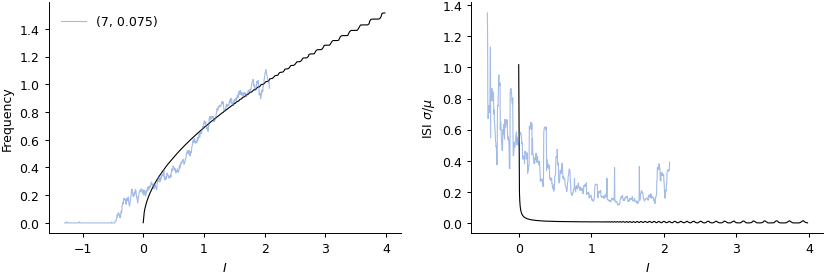

,[ 1.89982596 0.6 -1.14136253] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

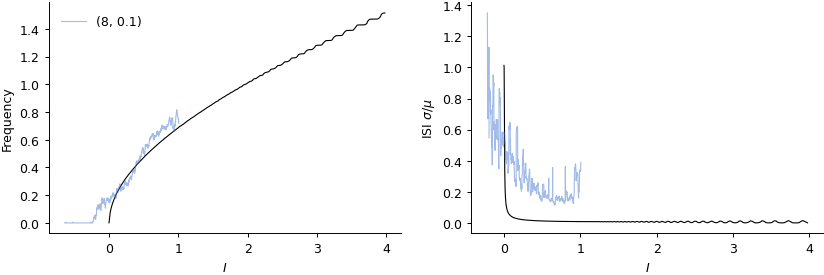

,[ 1.34512086 0.60006303 -0.63220211] [[ 0.84767667 4.23838336] [ 0.6 2. ] [-2.85 0.85 ]]

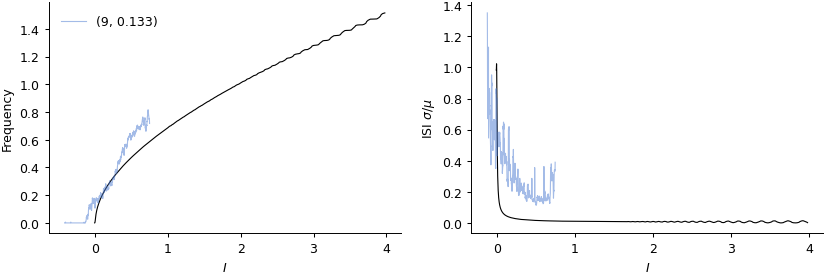

,[ 1.61113028 0.60000011 -0.76328491] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

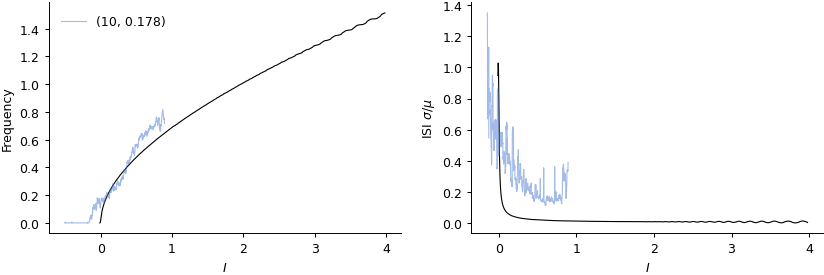

,[ 0.69063168 0.60029088 -0.33187411] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

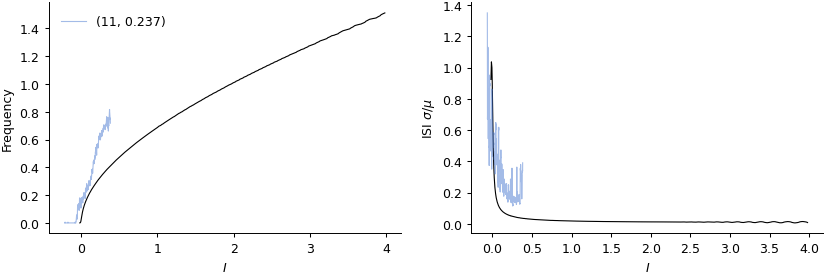

,[ 1.68922485 0.60001461 -0.93873336] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

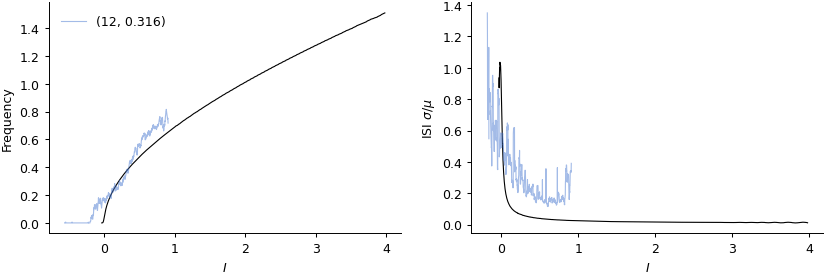

,[ 1.71409573 0.60090278 -1.0259142 ] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

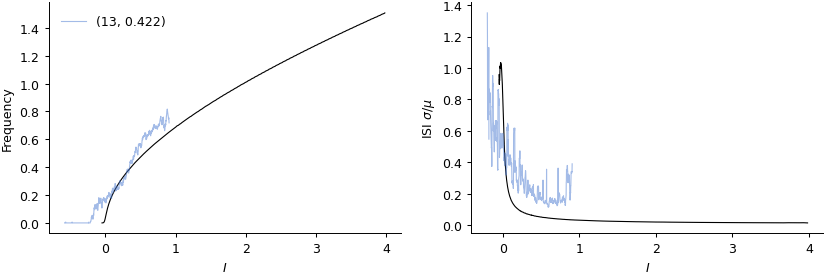

,[ 0.74075239 0.60000272 -0.20853394] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

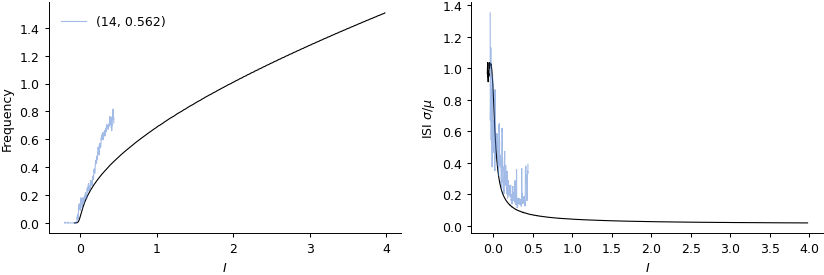

,[ 1.63788597 0.6000008 -0.97620567] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

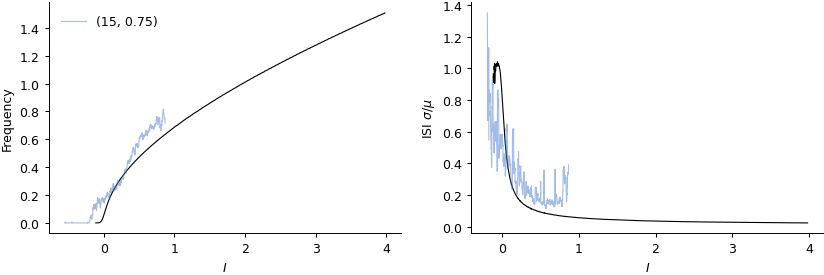

,[ 1.00511935 0.60159715 -0.22996788] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

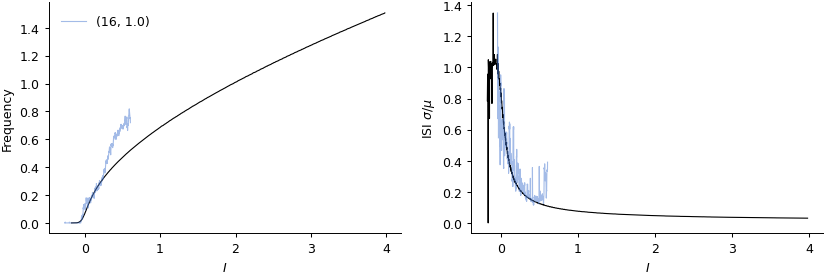

,[ 1.17596594 0.60624079 -0.28402133] [[ 0.36656289 1.83281443] [ 0.6 2. ] [-1.8 -0.2 ]]

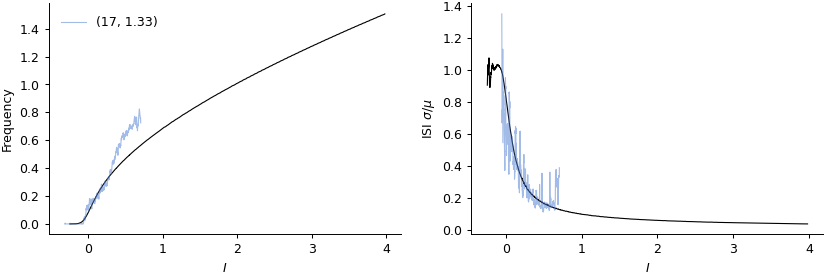

,[ 1.26854245 0.60000003 -0.10687087] [[ 0.32074252 1.60371262] [ 0.6 2. ] [-1.5 -0.1 ]]

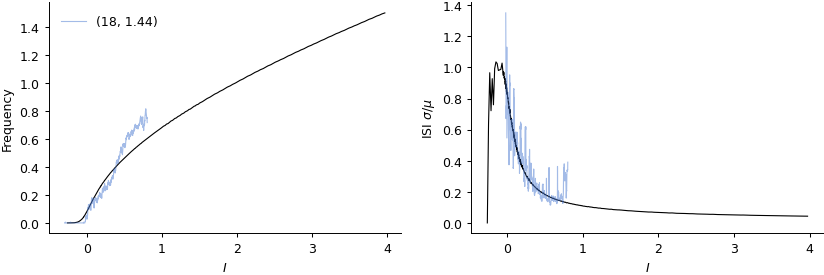

,[ 1.45050797 0.60224376 -0.10012056] [[ 0.32074252 1.60371262] [ 0.6 2. ] [-1.5 -0.1 ]]

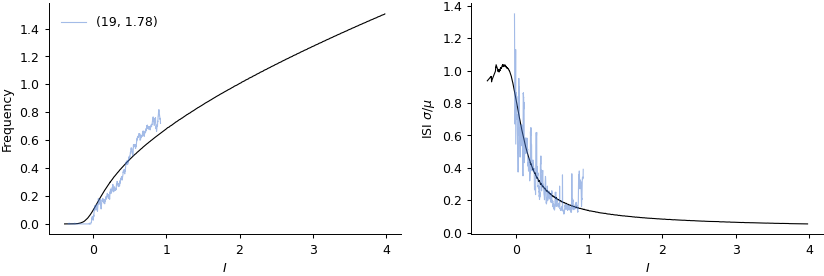

/tmp/ipykernel_214138/1547335857.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axes = plt.subplots(1, 2, figsize=(10,3))


,[ 1.51971756 0.60026601 -0.10429591] [[ 0.32074252 1.60371262] [ 0.6 2. ] [-1.5 -0.1 ]]

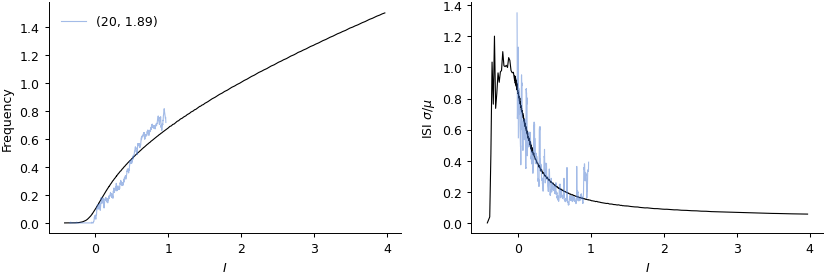

,[ 1.50167782 0.600587 -0.19612681] [[ 0.32074252 1.60371262] [ 0.6 2. ] [-1.5 -0.1 ]]

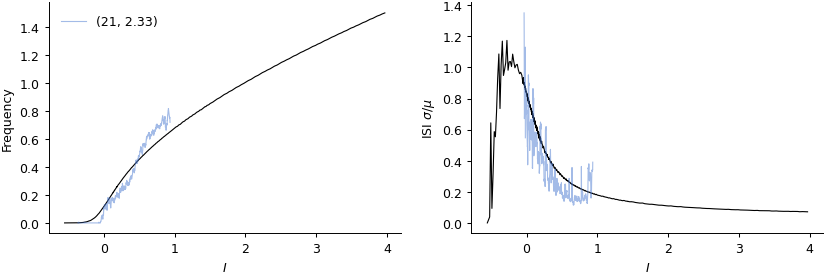

,[ 1.6036696 0.61658352 -0.13933507] [[ 0.32074252 1.60371262] [ 0.6 2. ] [-1.5 -0.1 ]]

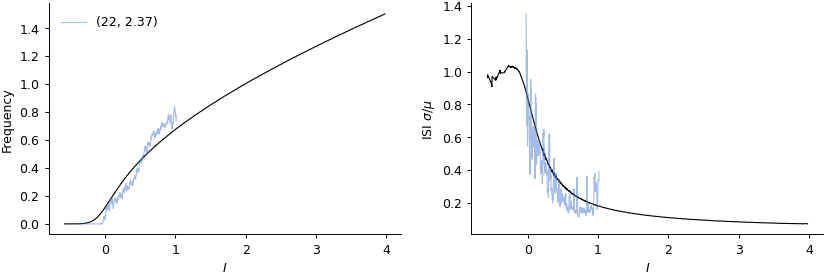

,[ 1.48906388 0.60026417 -0.37982418] [[ 0.29783234 1.48916172] [ 0.6 2. ] [-1.35 -0.05 ]]

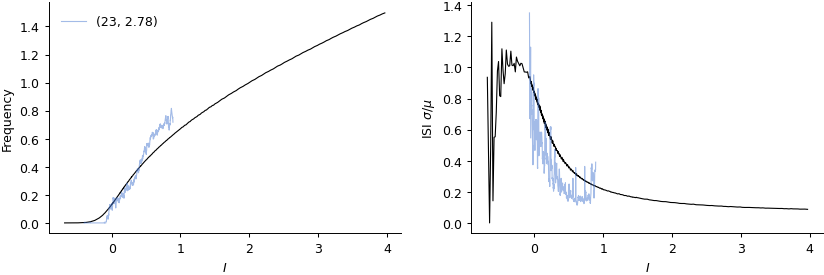

,[ 1.94615408 0.60323818 -0.2643113 ] [[ 0.38947307 1.94736533] [ 0.6 2. ] [-1.95 -0.25 ]]

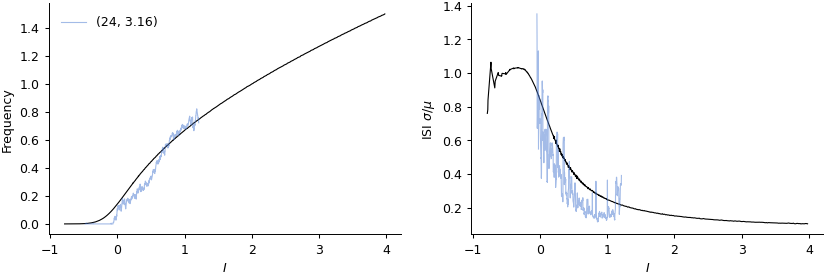

,[ 1.92240638 1.09562086 -0.58263281] [[ 0.38947307 1.94736533] [ 0.6 2. ] [-1.95 -0.25 ]]

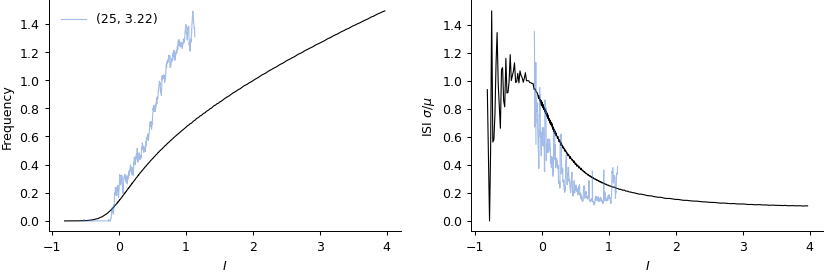

,[ 1.94736532 0.60540954 -0.25127982] [[ 0.38947307 1.94736533] [ 0.6 2. ] [-1.95 -0.25 ]]

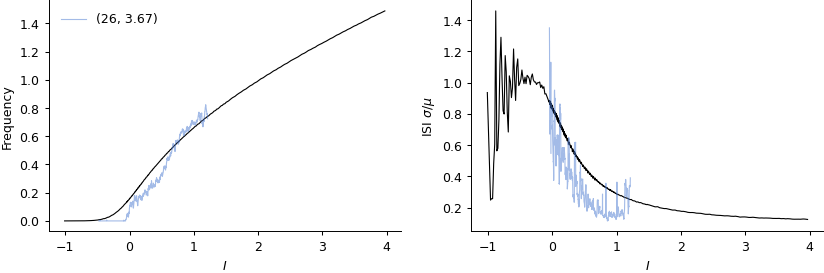

,[ 1.31222604 0.60274629 -0.25728101] [[ 0.38947307 1.94736533] [ 0.6 2. ] [-1.95 -0.25 ]]

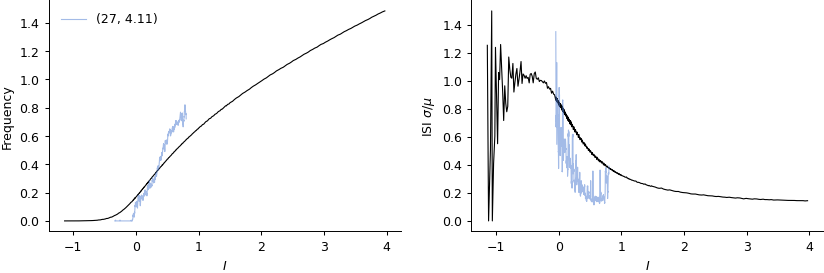

,[ 1.94735868 0.639835 -0.26339284] [[ 0.38947307 1.94736533] [ 0.6 2. ] [-1.95 -0.25 ]]

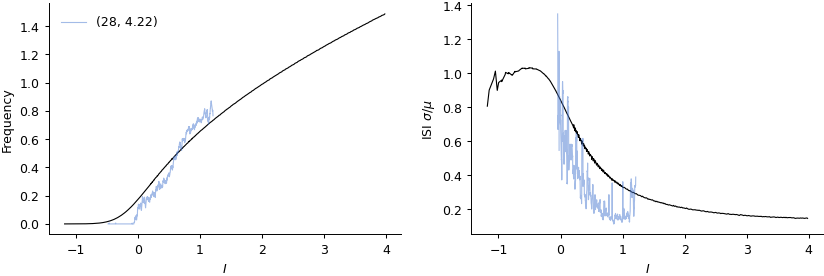

,[ 2.40556886 0.68479152 -0.48548364] [[ 0.48111379 2.40556894] [ 0.6 2. ] [-2.55 -0.45 ]]

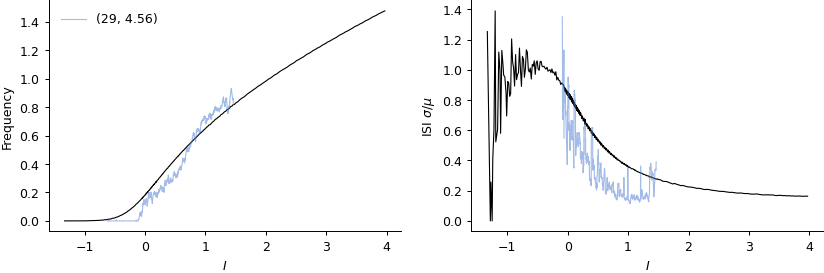

,[ 2.23556051 0.83445731 -1.06554576] [[ 0.61857487 3.09287435] [ 0.6 2. ] [-3.25 -0.55 ]]

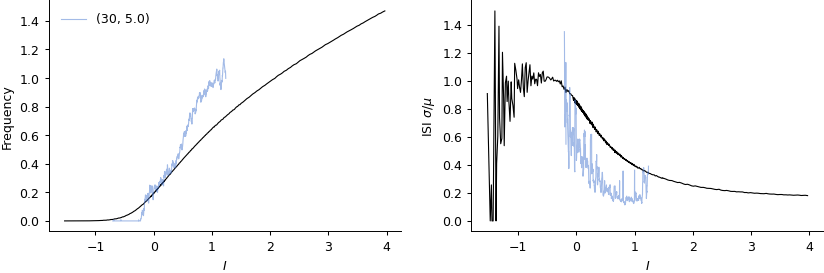

,[ 2.63408865 0.73249577 -0.39982869] [[ 0.52693415 2.63467074] [ 0.6 2. ] [-2.65 -0.35 ]]

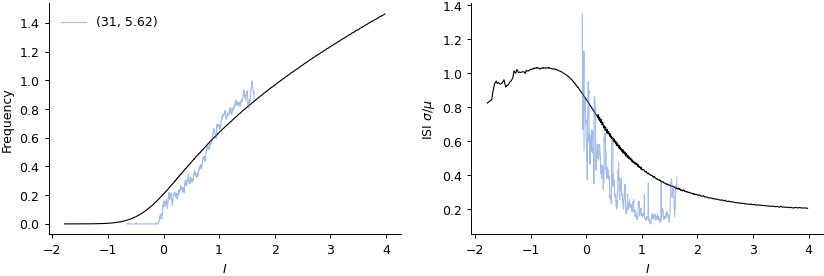

,[ 5.13416638 0.93333846 -0.23628886] [[ 1.0538683 5.26934148] [ 0.6 2. ] [-4.8 -0.2 ]]

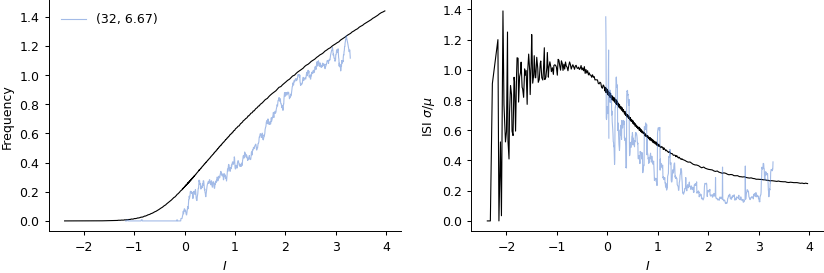

,[ 4.35292802 0.90889914 -1.00002082] [[ 0.87058685 4.35293427] [ 0.6 2. ] [-4.8 -1. ]]

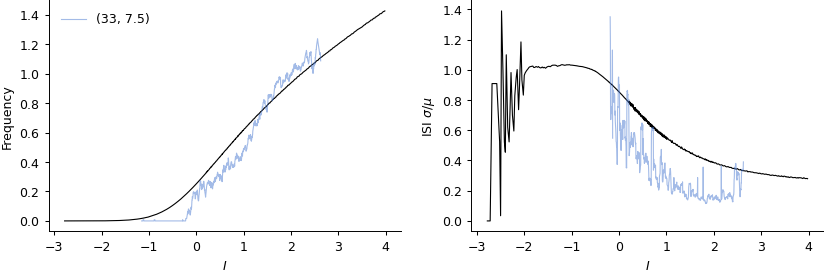

,[ 6.41558563 0.94156723 -1.00408526] [[ 4.37584445 21.87922223] [ 0.6 2. ] [-12.35 6.75 ]]

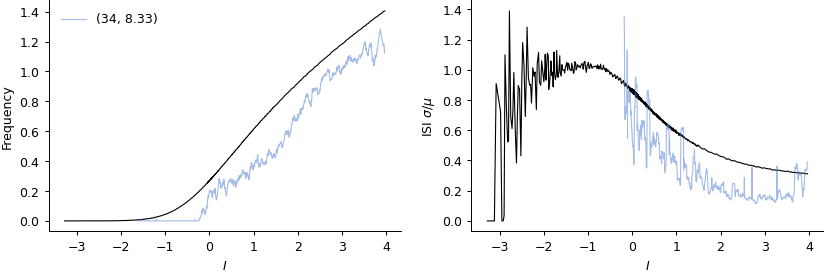

,[ 6.58166007 1.00524816 -0.56898158] [[ 4.3071139 21.53556952] [ 0.6 2. ] [-11.3 7.5 ]]

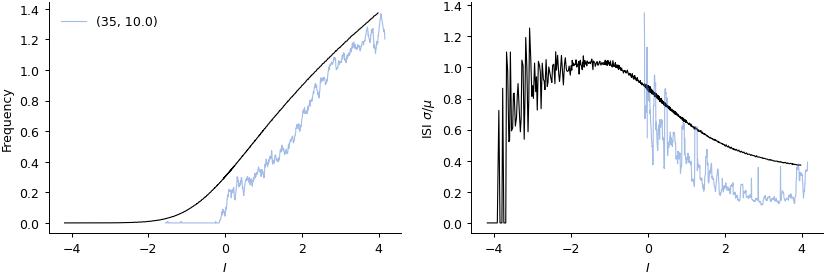

,[ 6.76840305 0.74508196 -2.11346167] [[ 4.44457499 22.22287493] [ 0.6 2. ] [-17.5 1.9 ]]

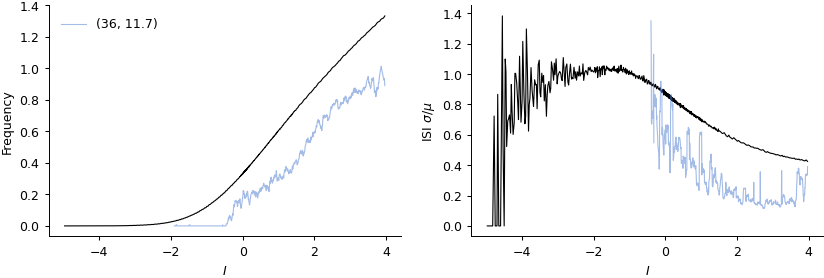

,[ 24.35849885 0.68204252 -14.98091517] [[ 5.40680256 27.03401281] [ 0.6 2. ] [-19.6 4. ]]

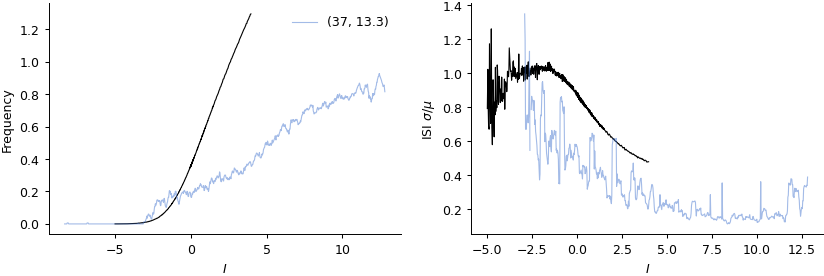

,[ 11.52334274 0.91544553 -17.08558802] [[ 5.08606004 25.43030018] [ 0.6 2. ] [-17.5 4.7 ]]

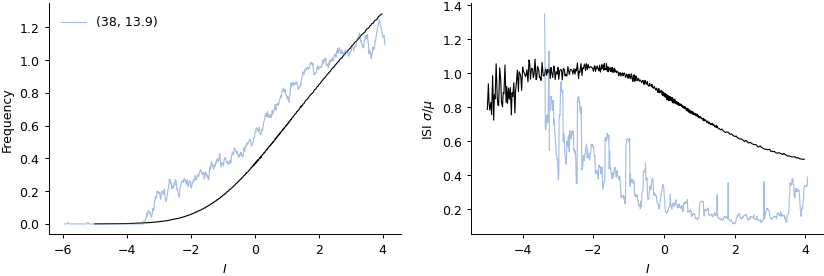

,[5.9722791 1.94899078 0.65189626] [[ 4.3071139 21.53556952] [ 0.6 2. ] [-17.2 1.6 ]]

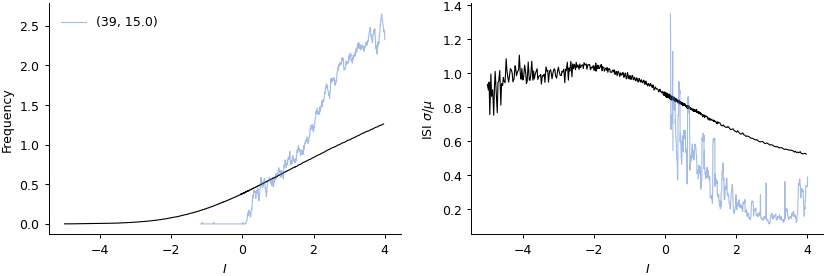

,[ 6.35058748 1.07254882 -0.75785208] [[ 5.97955707 29.89778535] [ 0.6 2. ] [-23.45 2.65 ]]

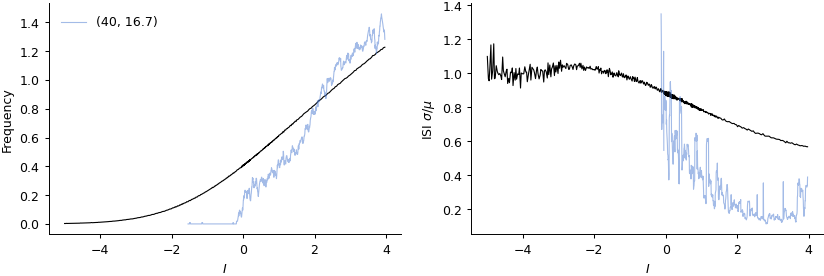

,[6.05637766 1.05284862 0.90110746] [[ 5.49844328 27.49221641] [ 0.6 2. ] [-22.4 1.6 ]]

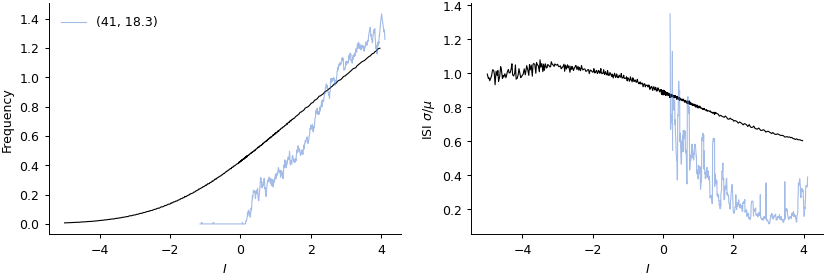

,[ 17.85542316 0.63239523 -37.64469849] [[ 7.62909005 38.14545027] [ 0.6 2. ] [-39.05 -5.75 ]]

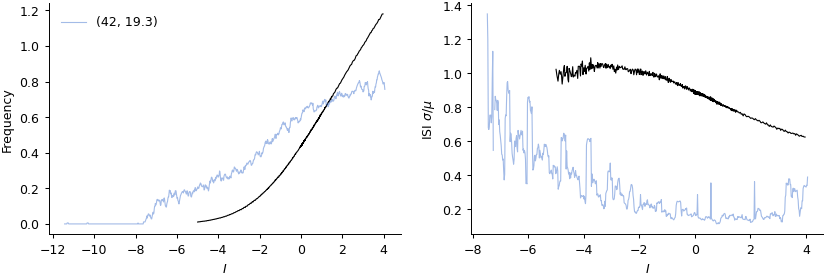

,[ 30.70040882 0.60343929 -39.09485461] [[ 8.2705751 41.35287552] [ 0.6 2. ] [-40.45 -4.35 ]]

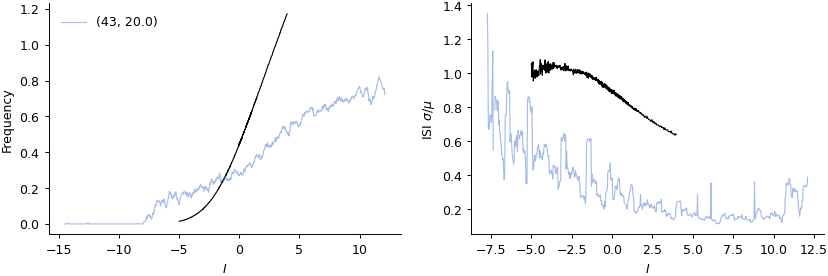

,[ 21.19558743 0.60129072 -18.16696303] [[ 5.63590436 28.17952182] [ 0.6 2. ] [-21.1 3.5 ]]

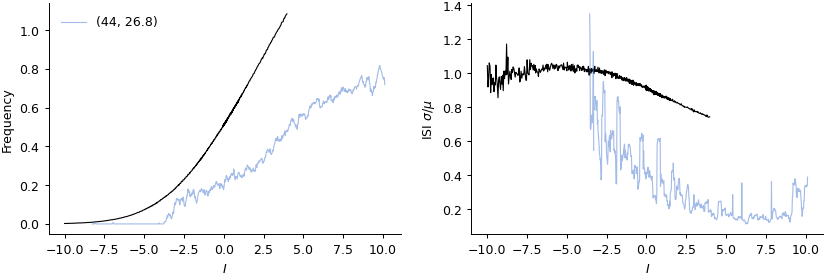

,[ 7.84312331 0.8185482 -4.24634391] [[ 7.83528168 39.17640839] [ 0.6 2. ] [-35.4 -1.2 ]]

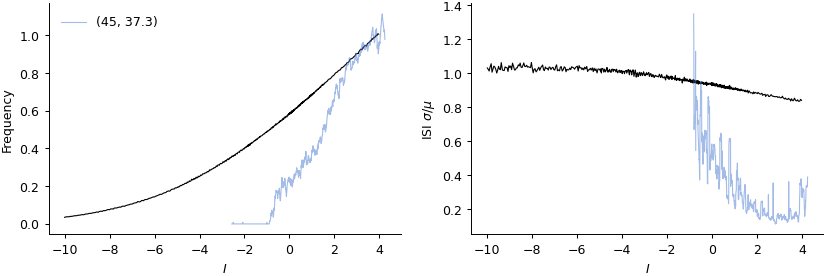

,[ 11.84330314 0.72527001 -18.46009565] [[ 5.86500617 29.32503084] [ 0.6 2. ] [-23.2 2.4 ]]

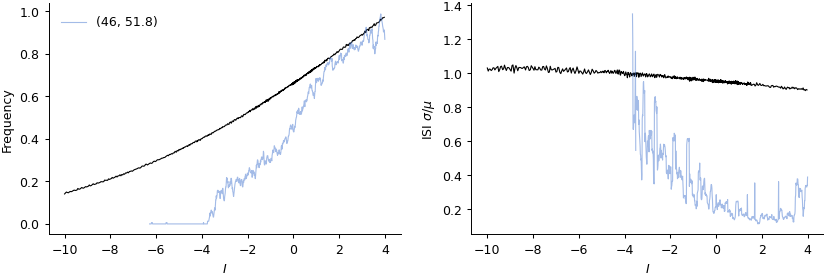

,[ 49.64761417 0.60021278 -50.15305573] [[ 9.98883863 49.94419315] [ 0.6 2. ] [-52.2 -8.6 ]]

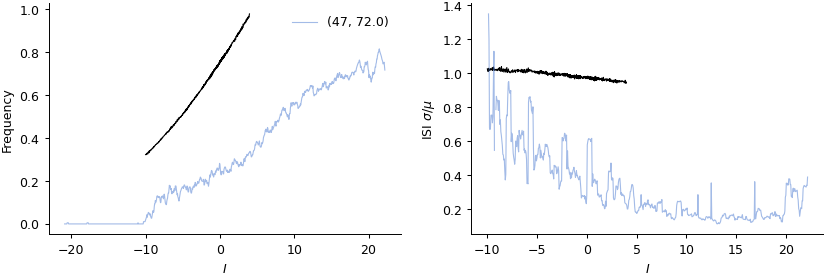

,[ 16.82325299 0.96727562 -34.65740873] [[ 7.78946132 38.94730659] [ 0.6 2. ] [-34.7 -0.7 ]]

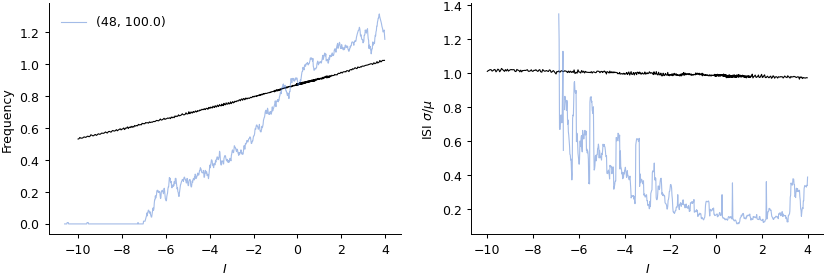

In [82]:
%matplotlib agg
e = 12
plt.close("all")
for row in range(len(sigmas)):
    fig1, axes = plt.subplots(1, 2, figsize=(10,3))
    frequency = f_sim[row,:]
    cov = cov_sim[row,:]
    xvals_data = np.arange(aligned_frequencies.shape[1])
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                    beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
    #     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
    finite_mask = np.isfinite(frequency) & np.isfinite(cov)
    axes[0].plot(rs[finite_mask], frequency[finite_mask], color="black")
    axes[1].plot(rs[finite_mask], cov[finite_mask], color="black")
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label=(row, sigmas[row]))
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
    axes[0].legend()
    axes[0].set_xlabel(r"$I$")
    axes[1].set_xlabel(r"$I$")
    axes[0].set_ylabel("Frequency")
    axes[1].set_ylabel(r"ISI $\sigma/\mu$")
#     axes[0].set_xlim(-0.5, 0.8)
#     axes[1].set_xlim(-0.5, 0.8)
#     axes[0].set_ylim(-0.05, 0.6)
    add_split_screen(fig1, str(beta_nm[e,row,:]) + "\r" + str(bounds[e,row,:,:]), iwidth=16)

(-0.05, 0.6)

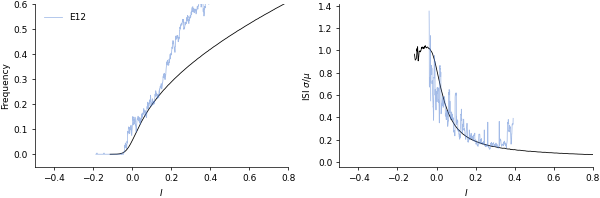

In [52]:
fig1, axes = plt.subplots(1, 2, figsize=(10,3))
e = 12
row = 15
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
#     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
finite_mask = np.isfinite(frequency) & np.isfinite(cov)
axes[0].plot(rs[finite_mask], frequency[finite_mask], color="black")
axes[1].plot(rs[finite_mask], cov[finite_mask], color="black")
f_expt = aligned_frequencies[e,:]
cov_expt = aligned_covs[e,:]
axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1], alpha=0.5, label="E%d" % e)
axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
axes[0].set_xlim(-0.5, 0.8)
axes[1].set_xlim(-0.5, 0.8)
axes[0].set_ylim(-0.05, 0.6)

Plot curve with best fit for each individual embryo

In [48]:
min_sigmas = np.nanargmin(err_nm, axis=1)

In [49]:
min_sigmas

array([20, 23, 15, 17, 18, 18, 18, 19, 23, 23, 18, 18, 18, 20, 23, 18, 34,
       18, 18, 18, 18, 34, 18, 23, 20, 23, 23, 24, 34, 23, 36, 23, 19, 36,
       34, 34, 23, 19, 19])

/tmp/ipykernel_248075/439845375.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axes = plt.subplots(1, 2, figsize=(10,3))


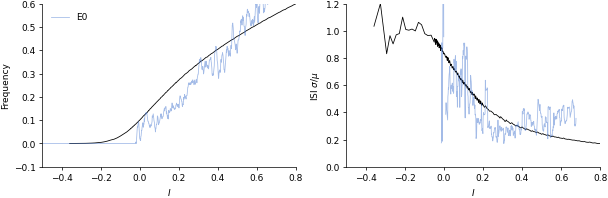

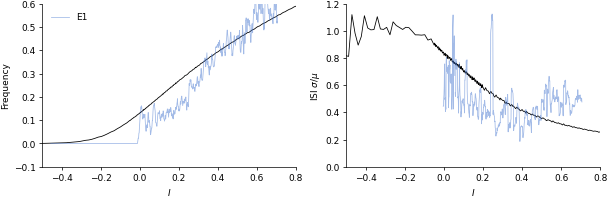

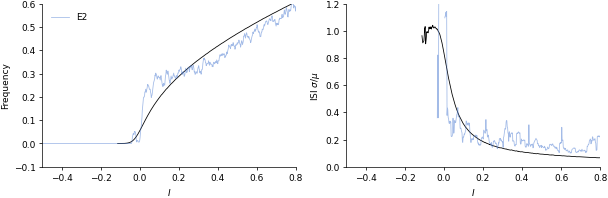

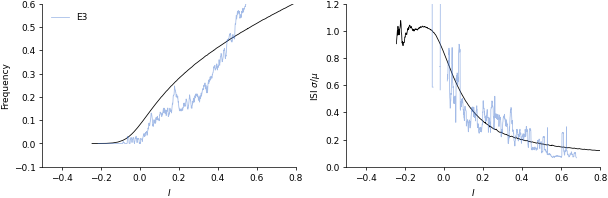

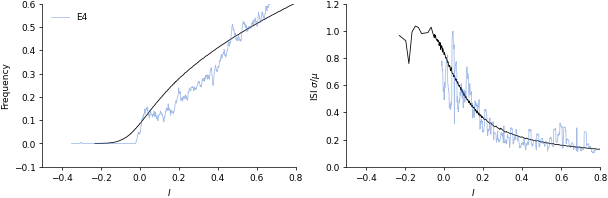

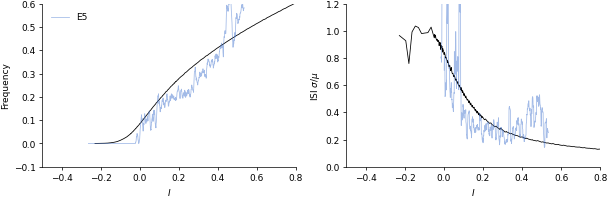

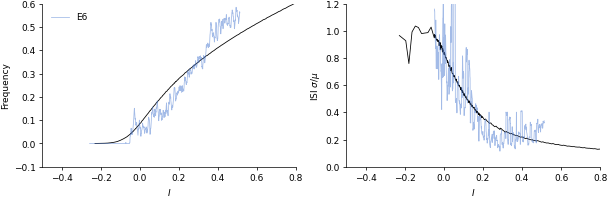

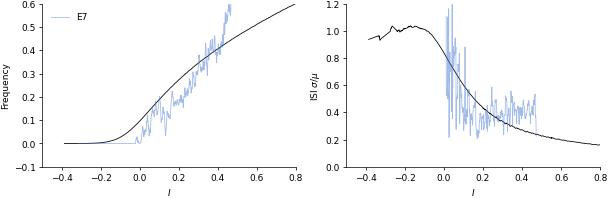

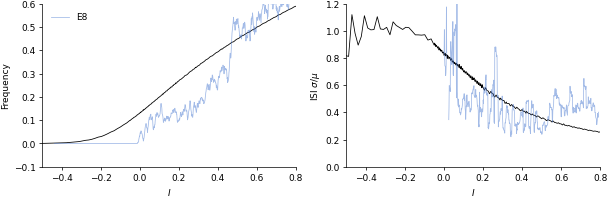

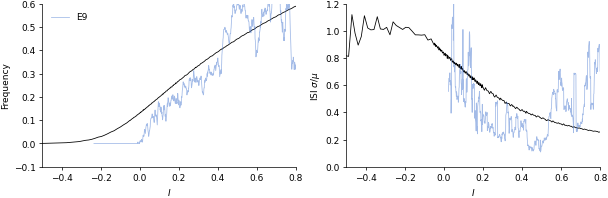

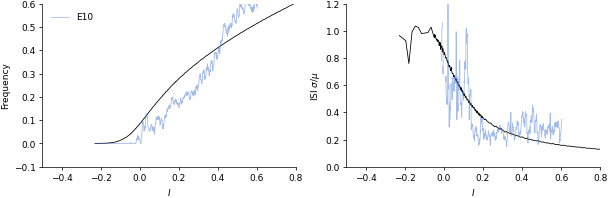

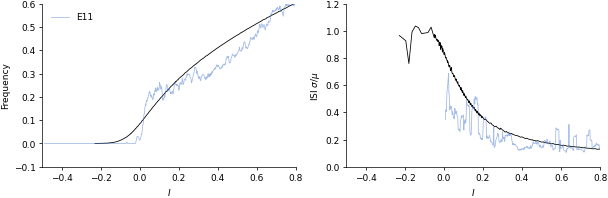

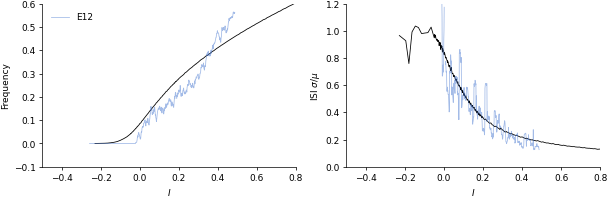

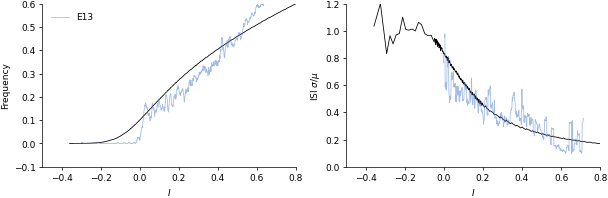

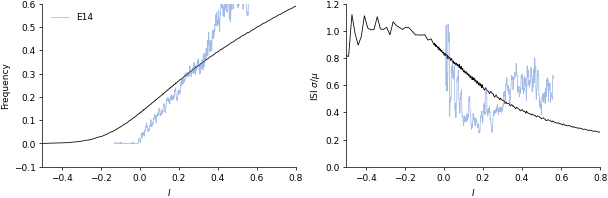

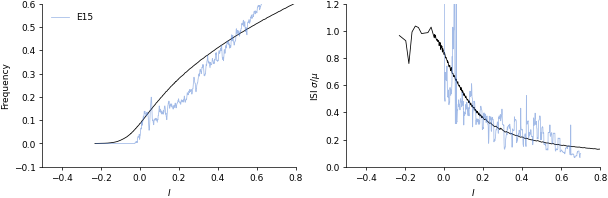

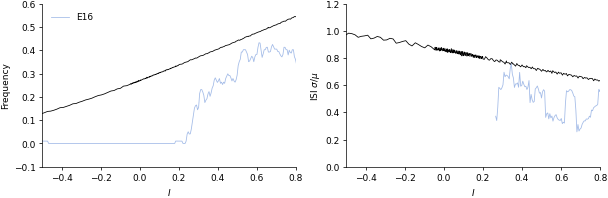

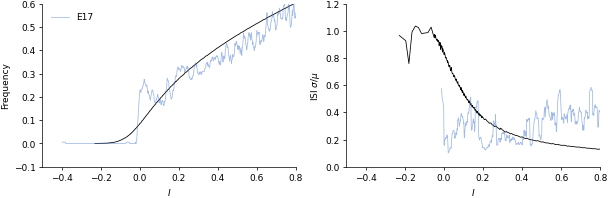

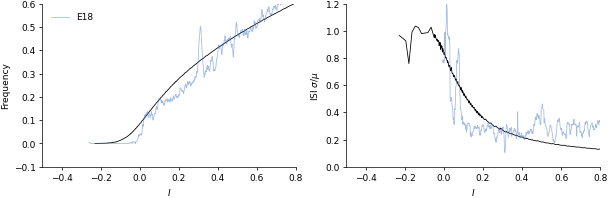

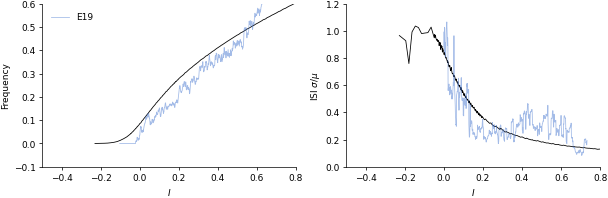

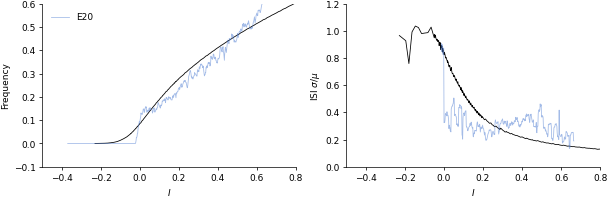

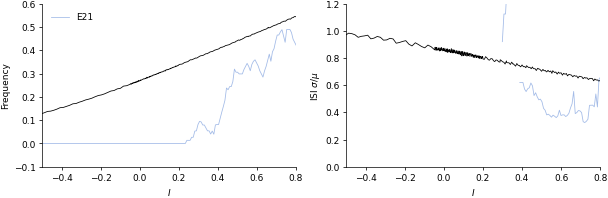

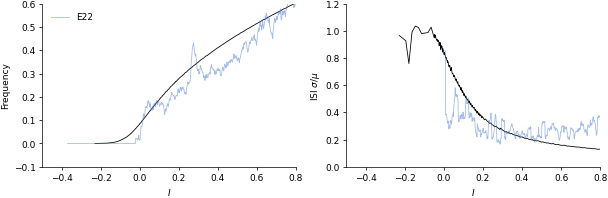

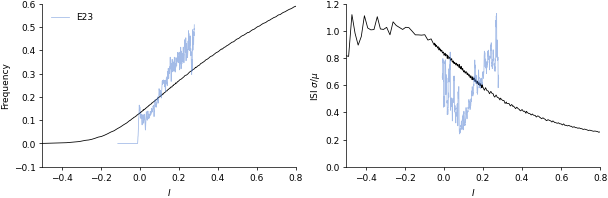

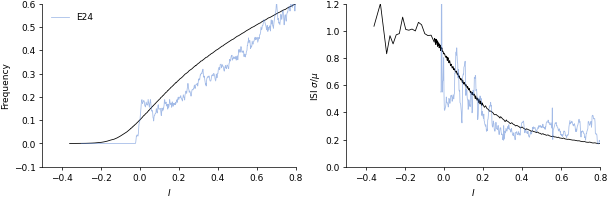

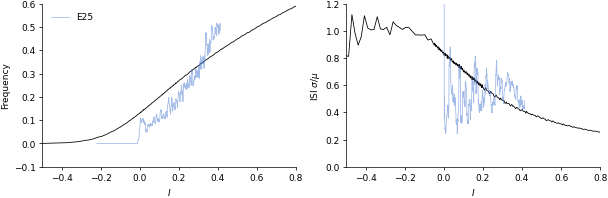

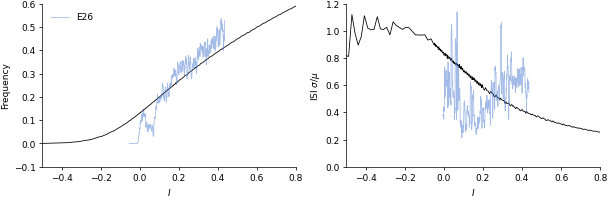

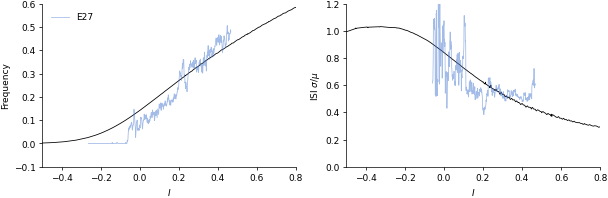

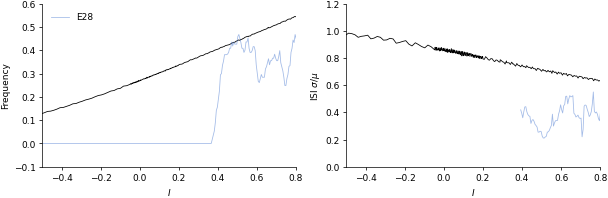

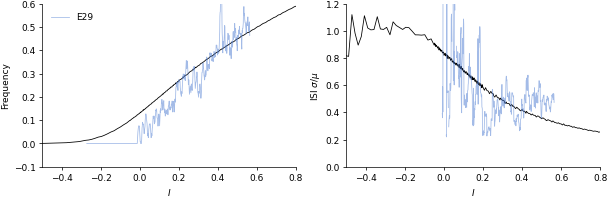

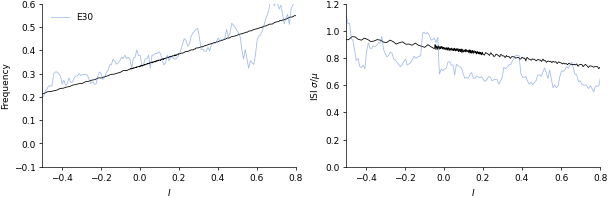

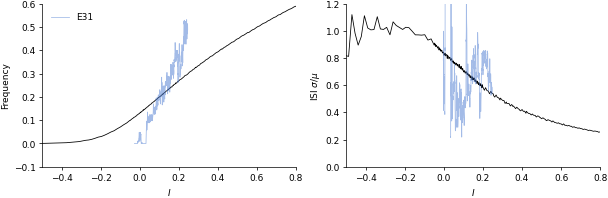

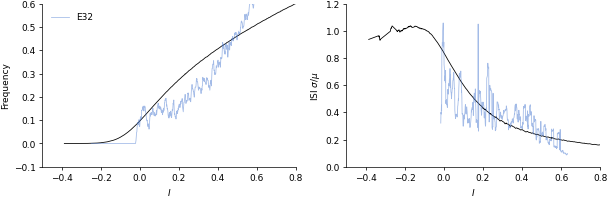

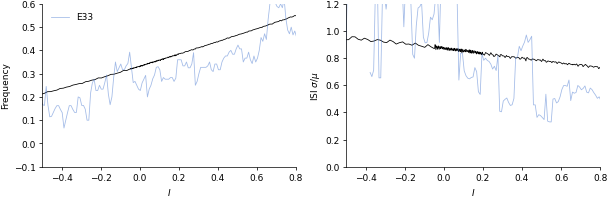

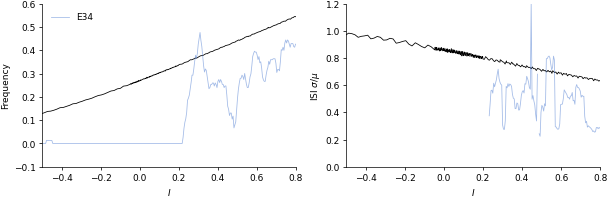

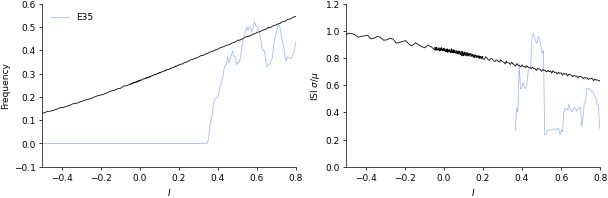

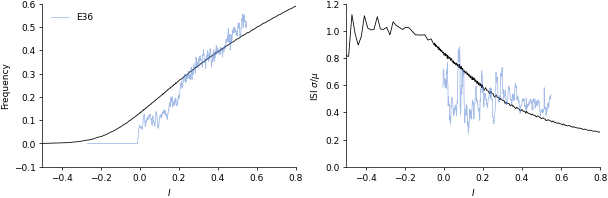

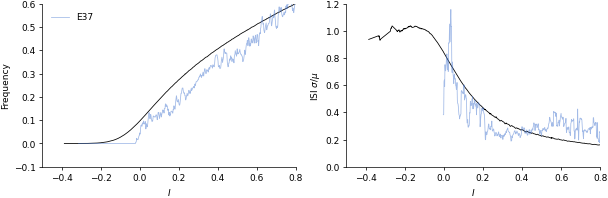

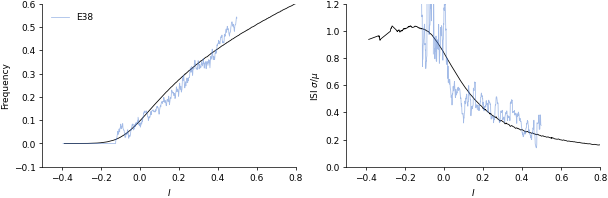

In [50]:
plt.close("all")
# axes = axes.ravel()
for e in range(aligned_frequencies.shape[0]):
    fig1, axes = plt.subplots(1, 2, figsize=(10,3))
    row = min_sigmas[e]
    first_idx = 0
    frequency = f_sim[row,first_idx:]
    cov = cov_sim[row,first_idx:]
    rs_plot = rs[first_idx:]
    cov[(rs < -0.2) & (cov < 0.8)] = np.nan
    xvals_data = np.arange(aligned_frequencies.shape[1])
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                    beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
#     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
    finite_mask = np.isfinite(frequency) & np.isfinite(cov)
    axes[0].plot(rs_plot[finite_mask], frequency[finite_mask], color="black")
    axes[1].plot(rs_plot[finite_mask], cov[finite_mask], color="black")
    
#     print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
    axes[0].legend()
    axes[0].set_xlabel(r"$I$")
    axes[1].set_xlabel(r"$I$")
    axes[0].set_ylabel("Frequency")
    axes[1].set_ylabel(r"ISI $\sigma/\mu$")
    xmax = 0.8
    axes[0].set_xlim((-0.5,xmax))
    axes[1].set_xlim((-0.5,xmax))
    axes[0].set_ylim((-0.1,0.6))
    axes[1].set_ylim(0, 1.2)

E6, E12, E15

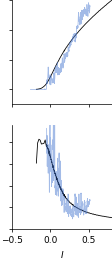

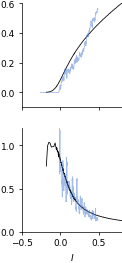

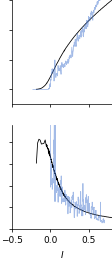

In [67]:
for e in [6, 12, 15]:
    fig1, axes = plt.subplots(2, 1, figsize=(1.8,4.2))
    row = min_sigmas[e]
    frequency = f_sim[row,:]
    cov = cov_sim[row,:]
    xvals_data = np.arange(aligned_frequencies.shape[1])
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                    beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
#     fig1, axes = plt.subplots(1, 2, figsize=(16,5))
    finite_mask = np.isfinite(frequency) & np.isfinite(cov)
    axes[0].plot(rs[finite_mask], frequency[finite_mask], color="black")
    axes[1].plot(rs[finite_mask], cov[finite_mask], color="black")
    
#     print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
#     axes[0].set_xlabel(r"$I$")
    axes[1].set_xlabel(r"$I$")
#     axes[0].set_ylabel("Frequency")
#     axes[1].set_ylabel(r"ISI $\sigma/\mu$")
    xmax = 0.8
    axes[0].set_xlim((-0.5,xmax))
    axes[1].set_xlim((-0.5,xmax))
    axes[0].set_ylim((-0.1,0.6))
    axes[1].set_ylim(0, 1.2)
    axes[0].get_xaxis().set_ticklabels([])
#     plt.tight_layout()
    if e==12:
        axes[1].set_yticks([0, 0.5, 1])
    else:
        axes[0].get_yaxis().set_ticklabels([])
        axes[1].get_yaxis().set_ticklabels([])
    plt.savefig(os.path.join(figdir, "Supplementary Figures", "QIF", "individuaL_fits_E%d.svg" % e))

20

In [69]:
# row = np.nanargmin(mean_lstsq)
row = 20
fitted_f_interpolation_functions = []
fitted_cv_interpolation_functions = []
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    
    xdat_f = xvals_data_scaled[e,~np.isnan(f_expt)]
    xdat_cov = xvals_data_scaled[e,~np.isnan(cov_expt)]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(cov_expt)]
    
    fitted_f_interpolation_functions.append(interpolate.interp1d(xdat_f, f_expt_masked*beta_nm[e,row,1]/scale_factors[1],\
                                                fill_value=(np.nan, np.nan), bounds_error=False))
    fitted_cv_interpolation_functions.append(interpolate.interp1d(xdat_cov, cov_expt_masked,\
                                                fill_value=(np.nan, np.nan), bounds_error=False))

data_disp_range = np.linspace(-0.4, 0.8, num=100)
all_xs = np.tile(data_disp_range, beta_nm.shape[0])
all_interp_fs = np.array([f(data_disp_range) for f in fitted_f_interpolation_functions])
all_interp_cvs = np.array([f(data_disp_range) for f in fitted_cv_interpolation_functions])

In [70]:
all_interp_fs.shape

(39, 100)

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


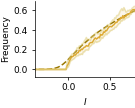

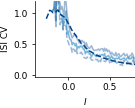

In [80]:
fig1, ax1 = plt.subplots(figsize=(1.8,1))
fig2, ax2 = plt.subplots(figsize=(1.8,1))

axes = [ax1, ax2]
display_offset = 0
pct25_freq, pct50_freq, pct75_freq = np.nanpercentile(all_interp_fs, [25,50, 75], axis=0)
pct25_cv, pct50_cv, pct75_cv = np.nanpercentile(all_interp_cvs, [25,50, 75], axis=0)


axes[0].plot(eq_sp_rs, f_interp[row], color="#997700", linewidth=1.5, linestyle="--")
axes[0].set_xlim(-0.4, 0.8)
axes[0].plot(data_disp_range, pct50_freq, color="#DDAA33", linewidth=1.5, alpha=1)
axes[0].fill_between(data_disp_range, pct25_freq, pct75_freq, color="#DDAA33", alpha=0.1)
axes[0].plot(data_disp_range, pct25_freq, color="#DDCC77", linewidth=1.5, alpha=0.5)
axes[0].plot(data_disp_range, pct75_freq, color="#DDCC77", linewidth=1.5, alpha=0.5)


axes[1].plot(data_disp_range, pct50_cv, color="#0077BB", linewidth=1.5, alpha=0.5)
axes[1].fill_between(data_disp_range, pct25_cv, pct75_cv, color="#BBCCEE", alpha=0.1)
axes[1].plot(data_disp_range, pct25_cv, color="#4477AA", linewidth=1.5, alpha=0.5)
axes[1].plot(data_disp_range, pct75_cv, color="#4477AA", linewidth=1.5, alpha=0.5)
axes[1].plot(eq_sp_rs, cov_interp[row], color="#004488", label="Model", linewidth=1.5,linestyle="--")
axes[1].set_xlim(-0.4, 0.8)



# sbs.lineplot(x=all_xs.ravel()-display_offset,\
#              y=all_interp_fs.ravel(), ax=axes[0], color="#539AD4")
# axes[0].lines[0].set_linestyle("--")
axes[0].set_xlabel(r"$I$")

axes[0].set_ylabel("Frequency")
axes[0].set_ylim(None, 0.7)

# sbs.lineplot(x=all_xs.ravel()-display_offset, \
#              y=all_interp_cvs.ravel(), ax=axes[1], color="#539AD4")

axes[1].lines[1].set_label(r"Experiment")
# axes[1].legend()
axes[1].lines[1].set_linestyle("--")
axes[1].set_ylim(None, 1.2)
axes[1].set_ylabel(r"ISI CV")
axes[1].set_xlabel(r"$I$")
axes[1].set_yticks([0, 0.5, 1])
fig1.set_size_inches(1.8, 1.4, forward=True)
fig2.set_size_inches(1.8, 1.4, forward=True)
plt.figure(1)
plt.savefig(os.path.join(figdir, "v13", "Figure2", "frequency_fit_QIF.svg"))
plt.figure(2)
plt.savefig(os.path.join(figdir, "v13", "Figure2", "cv_fit_QIF.svg"))

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


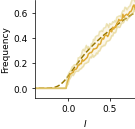

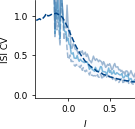

In [107]:
fig1, ax1 = plt.subplots(figsize=(1.8,1.8))
fig2, ax2 = plt.subplots(figsize=(1.8,1.8))

axes = [ax1, ax2]
display_offset = 0
pct25_freq, pct50_freq, pct75_freq = np.nanpercentile(all_interp_fs, [25,50, 75], axis=0)
pct25_cv, pct50_cv, pct75_cv = np.nanpercentile(all_interp_cvs, [25,50, 75], axis=0)


axes[0].plot(eq_sp_rs, f_interp[row], color="#997700", linewidth=1.5, linestyle="--")
axes[0].set_xlim(-0.4, 0.8)
axes[0].plot(data_disp_range, pct50_freq, color="#DDAA33", linewidth=1.5, alpha=1)
axes[0].fill_between(data_disp_range, pct25_freq, pct75_freq, color="#DDAA33", alpha=0.1)
axes[0].plot(data_disp_range, pct25_freq, color="#DDCC77", linewidth=1.5, alpha=0.5)
axes[0].plot(data_disp_range, pct75_freq, color="#DDCC77", linewidth=1.5, alpha=0.5)


axes[1].plot(data_disp_range, pct50_cv, color="#0077BB", linewidth=1.5, alpha=0.5)
axes[1].fill_between(data_disp_range, pct25_cv, pct75_cv, color="#BBCCEE", alpha=0.1)
axes[1].plot(data_disp_range, pct25_cv, color="#4477AA", linewidth=1.5, alpha=0.5)
axes[1].plot(data_disp_range, pct75_cv, color="#4477AA", linewidth=1.5, alpha=0.5)
axes[1].plot(eq_sp_rs, cov_interp[row], color="#004488", label="Model", linewidth=1.5,linestyle="--")
axes[1].set_xlim(-0.4, 0.8)



# sbs.lineplot(x=all_xs.ravel()-display_offset,\
#              y=all_interp_fs.ravel(), ax=axes[0], color="#539AD4")
# axes[0].lines[0].set_linestyle("--")
axes[0].set_xlabel(r"$I$")

axes[0].set_ylabel("Frequency")
axes[0].set_ylim(None, 0.7)

# sbs.lineplot(x=all_xs.ravel()-display_offset, \
#              y=all_interp_cvs.ravel(), ax=axes[1], color="#539AD4")

axes[1].lines[1].set_label(r"Experiment")
# axes[1].legend()
axes[1].lines[1].set_linestyle("--")
axes[1].set_ylim(None, 1.2)
axes[1].set_ylabel(r"ISI CV")
axes[1].set_xlabel(r"$I$")
axes[1].set_yticks([0, 0.5, 1])
fig1.set_size_inches(1.8, 1.8, forward=True)
fig2.set_size_inches(1.8, 1.8, forward=True)
plt.figure(1)
plt.savefig(os.path.join(figdir, "v12", "Figure2", "frequency_fit_QIF.svg"))
plt.figure(2)
plt.savefig(os.path.join(figdir, "v12", "Figure2", "cv_fit_QIF.svg"))


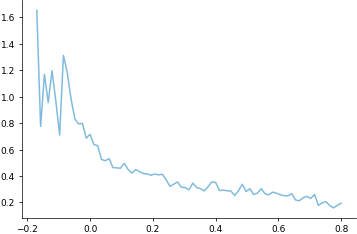

In [113]:
plt.plot(data_disp_range, pct50_cv, color="#0077BB", linewidth=1.5, alpha=0.5)

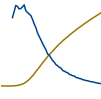

In [82]:
fig1, ax1 = plt.subplots(figsize=(1.8,1.8))
ax1.plot(eq_sp_rs, f_interp[row], color="#997700", linewidth=1.5)
ax2 = ax1.twinx()
ax2.plot(eq_sp_rs, cov_interp[row], color="#004488", linewidth=1.5)
ax1.set_xlim(-0.4, 0.8)
ax1.set_ylim(-0.1, 0.7)
ax1.set_axis_off()
ax2.set_axis_off()
plt.savefig(os.path.join(figdir, "v13", "Figure2", "QIF_moments_sketch.svg"))

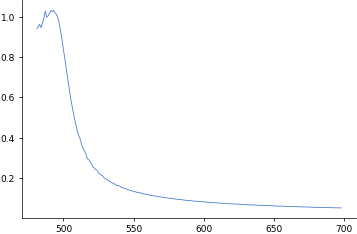

In [101]:
plt.plot(cov_interp[row])